In [ ]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 25.0 MB 3.6 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 30.6 MB 1.8 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
import time
import cv2
import glob
import os
import pickle
import numpy as np
import random
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.kernel_approximation import AdditiveChi2Sampler
from sklearn.svm import LinearSVC

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Computer Vision/

/content/drive/MyDrive/Colab Notebooks/Computer Vision


# Load Dataset

In [ ]:
start_time = time.time()

def scene15():
    train_folders = glob.glob("SCENE-15/train/*")
    train_folders.sort()
    classes = dict()
    x_train = list()
    y_train = list()
    for index, folder in enumerate(train_folders):
        label = os.path.basename(folder)
        classes[label] = index
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_train.append(cv2.imread(path, 0))
            y_train.append(index)

    x_test = list()
    y_test = list()
    test_folders = glob.glob("SCENE-15/test/*")
    test_folders.sort()
    for folder in test_folders:
        label = os.path.basename(folder)
        index = classes[label]
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_test.append(cv2.imread(path, 0))
            y_test.append(index)

    return x_train, y_train, x_test, y_test, sorted(classes.keys())

x_train, y_train, x_test, y_test, labels_names = scene15()

random_indices = list(range(len(y_train)))
random.shuffle(random_indices)
x_train = np.array(x_train)[random_indices].tolist()
y_train = np.array(y_train)[random_indices].tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


# Extract Patches

In [ ]:
def extract_patches(patch_stride):
  train_key_points = list()
  train_feature_shapes = list()
  for image in x_train:
      h, w = image.shape
      image_key_points = list()
      for x in range(0, w, patch_stride):
          for y in range(0, h, patch_stride):
              image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
      train_key_points.append(image_key_points)
      train_feature_shapes.append((len(range(0, w, patch_stride)), (len(range(0, h, patch_stride)))))

  test_key_points = list()
  test_feature_shapes = list()
  for image in x_test:
      h, w = image.shape
      image_key_points = list()
      for x in range(0, w, patch_stride):
          for y in range(0, h, patch_stride):
              image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
      test_key_points.append(image_key_points)
      test_feature_shapes.append((len(range(0, w, patch_stride)), (len(range(0, h, patch_stride)))))
  return train_key_points, train_feature_shapes, test_key_points, test_feature_shapes

p8_train_key_points, p8_train_feature_shapes, p8_test_key_points, p8_test_feature_shapes = extract_patches(patch_stride = 8)
p16_train_key_points, p16_train_feature_shapes, p16_test_key_points, p16_test_feature_shapes = extract_patches(patch_stride = 16)
p32_train_key_points, p32_train_feature_shapes, p32_test_key_points, p32_test_feature_shapes = extract_patches(patch_stride = 32)

# Extract Features

In [ ]:
def extract_features(desc, train_key_points, test_key_points):
  ###################################################################################
  # 1) descriptor를 선정하세요. (SIFT, SURF 등) OpenCV의 패키지를 사용하시면 됩니다.
  # 2) for 반복문 안에서, 1)에서 정의한 descriptor를 통하여 features를 추출하세요.
  #    features의 차원은 (# of keypoints, feature_dim) 입니다.
  ###################################################################################
  # Write Your Code Here ############################################################
  if desc == "SIFT":
    descriptor = cv2.xfeatures2d.SIFT_create()
  elif desc == "SURF":
    descriptor = cv2.xfeatures2d.SURF_create(extended = True, upright = True)
  ###################################################################################
  train_features = list()
  index = 0
  for image, key_points in zip(x_train, train_key_points):
      # Write Your Code Here ########################################################
      _, features = descriptor.compute(image, key_points)
      ###############################################################################
      train_features.append(features)
      index += 1
      if index % 100 == 0:
        print("Extract Train Features ... {:4d}/{:4d}".format(index, len(x_train)))

  test_features = list()
  index = 0
  for image, key_points in zip(x_test, test_key_points):
      # Write Your Code Here ########################################################
      _, features = descriptor.compute(image, key_points)
      ###############################################################################
      test_features.append(features)
      index += 1
      if index % 100 == 0:
        print("Extract Test Features ... {:4d}/{:4d}".format(index, len(x_test)))
  return train_features, test_features

SIFT8_train_features, SIFT8_test_features = extract_features("SIFT", p8_train_key_points, p8_test_key_points)
SIFT16_train_features, SIFT16_test_features = extract_features("SIFT", p16_train_key_points, p16_test_key_points)
SIFT32_train_features, SIFT32_test_features = extract_features("SIFT", p32_train_key_points, p32_test_key_points)

SURF8_train_features, SURF8_test_features = extract_features("SURF", p8_train_key_points, p8_test_key_points)
SURF16_train_features, SURF16_test_features = extract_features("SURF", p16_train_key_points, p16_test_key_points)
SURF32_train_features, SURF32_test_features = extract_features("SURF", p32_train_key_points, p32_test_key_points)

Extract Train Features ...  100/1500
Extract Train Features ...  200/1500
Extract Train Features ...  300/1500
Extract Train Features ...  400/1500
Extract Train Features ...  500/1500
Extract Train Features ...  600/1500
Extract Train Features ...  700/1500
Extract Train Features ...  800/1500
Extract Train Features ...  900/1500
Extract Train Features ... 1000/1500
Extract Train Features ... 1100/1500
Extract Train Features ... 1200/1500
Extract Train Features ... 1300/1500
Extract Train Features ... 1400/1500
Extract Train Features ... 1500/1500
Extract Test Features ...  100/1500
Extract Test Features ...  200/1500
Extract Test Features ...  300/1500
Extract Test Features ...  400/1500
Extract Test Features ...  500/1500
Extract Test Features ...  600/1500
Extract Test Features ...  700/1500
Extract Test Features ...  800/1500
Extract Test Features ...  900/1500
Extract Test Features ... 1000/1500
Extract Test Features ... 1100/1500
Extract Test Features ... 1200/1500
Extract Test 

# Normalizing

In [ ]:
def normalizing(train_features, test_features):
  flattened_train_features = np.concatenate(train_features, axis=0)
  pca = PCA(n_components=flattened_train_features.shape[-1], whiten=True)
  pca.fit(flattened_train_features)

  train_normalized_features = list()
  index = 0

  for features in train_features:
      features = pca.transform(features)
      train_normalized_features.append(features)
      index += 1
      if index %100 == 0:
        print("Normalize Train Features ... {:4d}/{:4d}".format(index, len(train_features)))

  test_normalized_features = list()
  index = 0
  for features in test_features:
      features = pca.transform(features)
      test_normalized_features.append(features)
      index += 1
      if index%100 == 0:
        print("Normalize Test Features ... {:4d}/{:4d}".format(index, len(test_features)))

  return pca, flattened_train_features, train_normalized_features, test_normalized_features

pca, SIFT8_flattened_train_features, SIFT8_train_normalized_features, SIFT8_test_normalized_features = normalizing(SIFT8_train_features, SIFT8_test_features)
SIFT8_flattened_normalized_train_features = pca.transform(SIFT8_flattened_train_features)

pca, SIFT16_flattened_train_features, SIFT16_train_normalized_features, SIFT16_test_normalized_features = normalizing(SIFT16_train_features, SIFT16_test_features)
SIFT16_flattened_normalized_train_features = pca.transform(SIFT16_flattened_train_features)

pca, SIFT32_flattened_train_features, SIFT32_train_normalized_features, SIFT32_test_normalized_features = normalizing(SIFT32_train_features, SIFT32_test_features)
SIFT32_flattened_normalized_train_features = pca.transform(SIFT32_flattened_train_features)

pca, SURF8_flattened_train_features, SURF8_train_normalized_features, SURF8_test_normalized_features = normalizing(SURF8_train_features, SURF8_test_features)
SURF8_flattened_normalized_train_features = pca.transform(SURF8_flattened_train_features)

pca, SURF16_flattened_train_features, SURF16_train_normalized_features, SURF16_test_normalized_features = normalizing(SURF16_train_features, SURF16_test_features)
SURF16_flattened_normalized_train_features = pca.transform(SURF16_flattened_train_features)

pca, SURF32_flattened_train_features, SURF32_train_normalized_features, SURF32_test_normalized_features = normalizing(SURF32_train_features, SURF32_test_features)
SURF32_flattened_normalized_train_features = pca.transform(SURF32_flattened_train_features)

Normalize Train Features ...  100/1500
Normalize Train Features ...  200/1500
Normalize Train Features ...  300/1500
Normalize Train Features ...  400/1500
Normalize Train Features ...  500/1500
Normalize Train Features ...  600/1500
Normalize Train Features ...  700/1500
Normalize Train Features ...  800/1500
Normalize Train Features ...  900/1500
Normalize Train Features ... 1000/1500
Normalize Train Features ... 1100/1500
Normalize Train Features ... 1200/1500
Normalize Train Features ... 1300/1500
Normalize Train Features ... 1400/1500
Normalize Train Features ... 1500/1500
Normalize Test Features ...  100/1500
Normalize Test Features ...  200/1500
Normalize Test Features ...  300/1500
Normalize Test Features ...  400/1500
Normalize Test Features ...  500/1500
Normalize Test Features ...  600/1500
Normalize Test Features ...  700/1500
Normalize Test Features ...  800/1500
Normalize Test Features ...  900/1500
Normalize Test Features ... 1000/1500
Normalize Test Features ... 1100/15

# Make Codebook

In [ ]:
###################################################################################
# 1) 함수 encode 부분 안의 None 부분을 채우세요.
#    distances는 K means 알고리즘을 통해 얻어진 centroids, 즉 codewords(visual words)와
#    각 이미지의 특징들 간의 거리 입니다.
#    distances 값을 이용하여, features(# of keypoints, feature_dim)를
#    인코딩(histogram 혹은 quantization이라고도 함) 하세요.
#    인코딩된 결과인 representations은 (K)로 표현되어야 합니다.
#    이 때, K는 codewords의 개수입니다.
###################################################################################
class Codebook:
    def __init__(self, K):
        self.K = K
        self.kmeans = KMeans(n_clusters=K, verbose=True)

    def make_code_words(self, features):
        self.kmeans.fit(features)
        return self.kmeans.cluster_centers_

    def encode(self, features, shapes, mode):
        distances = self.kmeans.transform(features)

        if mode == "spatial":
            level_0 = np.histogram(np.argmin(distances, axis=1), bins = np.arange(self.K + 1))[0] * 1/4
            # reshaped_features는 Spatial Pyramid Matching 문제에 활용하세요.
            reshaped_features = np.reshape(features, (shapes[0], shapes[1], -1))

            level1_region1 = reshaped_features[:shapes[0]//2, :shapes[1]//2, :]
            level1_region2 = reshaped_features[shapes[0]//2:, :shapes[1]//2, :]
            level1_region3 = reshaped_features[:shapes[0]//2, shapes[1]//2:, :]
            level1_region4 = reshaped_features[shapes[0]//2:, shapes[1]//2:, :]
            
            level_1 = np.asarray([])
            for region in [level1_region1,level1_region2,level1_region3,level1_region4]:
              dis = self.kmeans.transform(np.reshape(region, (region.shape[0]*region.shape[1], -1)))
              level_1 = np.append(level_1, np.histogram(np.argmin(dis, axis=1), bins = np.arange(self.K + 1))[0])
            level_1 *= 1/4
            
            level2_region1 = reshaped_features[:shapes[0]//3, :shapes[1]//3, :]
            level2_region2 = reshaped_features[shapes[0]//3:shapes[0]//3 *2, :shapes[1]//3, :]
            level2_region3 = reshaped_features[shapes[0]//3 *2:, :shapes[1]//3, :]
            level2_region4 = reshaped_features[:shapes[0]//3, shapes[1]//3:shapes[1]//3 *2, :]
            level2_region5 = reshaped_features[shapes[0]//3:shapes[0]//3 *2, shapes[1]//3:shapes[1]//3 *2, :]
            level2_region6 = reshaped_features[shapes[0]//3 *2:, shapes[1]//3:shapes[1]//3 *2, :]
            level2_region7 = reshaped_features[:shapes[0]//3, shapes[1]//3*2:, :]
            level2_region8 = reshaped_features[shapes[0]//3:shapes[0]//3 *2, shapes[1]//3*2:, :]
            level2_region9 = reshaped_features[shapes[0]//3 *2:, shapes[1]//3*2:, :]
      
            level_2 = np.asarray([])
            for region in [level2_region1,level2_region2,level2_region3,level2_region4,level2_region5, level2_region6, level2_region7, level2_region8, level2_region9]:
              dis = self.kmeans.transform(np.reshape(region, (region.shape[0]*region.shape[1], -1)))
              level_2 = np.append(level_2, np.histogram(np.argmin(dis, axis=1), bins = np.arange(self.K + 1))[0])
            level_2 *= 1/2

            representations = np.append(level_0, level_1)
            representations = np.append(representations, level_2)

        elif mode == "normal":
            # Write Your Code Here ########################################################
            representations = np.histogram(np.argmin(distances, axis=1), bins = np.arange(self.K+1))[0]
            ###############################################################################

            if np.array(representations).shape != (self.K, ):
                # representations는 반드시 (K) 차원을 가져야 합니다 (Spatial Pyramid Matching 사용 안할 시에만).
                print(np.array(representations).shape)
                print("Your code may be wrong")

        return representations

In [ ]:
print("Make 10 Centroids Codebook ...")

SIFT8_codebook10 = Codebook(K10)
centers = SIFT8_codebook10.make_code_words(SIFT8_flattened_normalized_train_features)

# SIFT16_codebook10 = Codebook(K10)
# centers = SIFT16_codebook10.make_code_words(SIFT16_flattened_normalized_train_features)

# SIFT32_codebook10 = Codebook(K10)
# centers = SIFT32_codebook10.make_code_words(SIFT32_flattened_normalized_train_features)

SURF8_codebook10 = Codebook(K10)
centers = SURF8_codebook10.make_code_words(SURF8_flattened_normalized_train_features)

# SURF16_codebook10 = Codebook(K10)
# centers = SURF16_codebook10.make_code_words(SURF16_flattened_normalized_train_features)

# SURF32_codebook10 = Codebook(K10)
# centers = SURF32_codebook10.make_code_words(SURF32_flattened_normalized_train_features)

Make 10 Centroids Codebook ...
Initialization complete
Iteration 0, inertia 320763392.0
Iteration 1, inertia 196921904.0
Iteration 2, inertia 196199728.0
Iteration 3, inertia 195638656.0
Iteration 4, inertia 195207424.0
Iteration 5, inertia 194941120.0
Iteration 6, inertia 194746480.0
Iteration 7, inertia 194598464.0
Iteration 8, inertia 194495408.0
Iteration 9, inertia 194421856.0
Iteration 10, inertia 194359680.0
Iteration 11, inertia 194304016.0
Iteration 12, inertia 194252416.0
Iteration 13, inertia 194207200.0
Iteration 14, inertia 194174944.0
Iteration 15, inertia 194146064.0
Iteration 16, inertia 194121056.0
Iteration 17, inertia 194095968.0
Iteration 18, inertia 194067728.0
Iteration 19, inertia 194041008.0
Iteration 20, inertia 194020544.0
Iteration 21, inertia 194005152.0
Iteration 22, inertia 193987504.0
Iteration 23, inertia 193967968.0
Iteration 24, inertia 193952064.0
Iteration 25, inertia 193943936.0
Iteration 26, inertia 193939936.0
Iteration 27, inertia 193937600.0
Ite

In [ ]:
print("Make 20 Centroids Codebook ...")
K10 = 10
K20 = 20
K30 = 30
SURF8_codebook20 = Codebook(K20)
centers = SURF8_codebook20.make_code_words(SURF8_flattened_normalized_train_features)

SURF16_codebook20 = Codebook(K20)
centers = SURF16_codebook20.make_code_words(SURF16_flattened_normalized_train_features)

SURF32_codebook20 = Codebook(K20)
centers = SURF32_codebook20.make_code_words(SURF32_flattened_normalized_train_features)

SIFT8_codebook20 = Codebook(K20)
centers = SIFT8_codebook20.make_code_words(SIFT8_flattened_normalized_train_features)

SIFT16_codebook20 = Codebook(K20)
centers = SIFT16_codebook20.make_code_words(SIFT16_flattened_normalized_train_features)

SIFT32_codebook20 = Codebook(K20)
centers = SIFT32_codebook20.make_code_words(SIFT32_flattened_normalized_train_features)

Make 20 Centroids Codebook ...
Initialization complete
Iteration 0, inertia 244798528.0
Iteration 1, inertia 190188880.0
Iteration 2, inertia 188376576.0
Iteration 3, inertia 187403328.0
Iteration 4, inertia 186649664.0
Iteration 5, inertia 186373184.0
Iteration 6, inertia 186214208.0
Iteration 7, inertia 186114976.0
Iteration 8, inertia 186035360.0
Iteration 9, inertia 185971904.0
Iteration 10, inertia 185925024.0
Iteration 11, inertia 185886400.0
Iteration 12, inertia 185845920.0
Iteration 13, inertia 185805760.0
Iteration 14, inertia 185766912.0
Iteration 15, inertia 185727104.0
Iteration 16, inertia 185676160.0
Iteration 17, inertia 185621040.0
Iteration 18, inertia 185569440.0
Iteration 19, inertia 185511296.0
Iteration 20, inertia 185457056.0
Iteration 21, inertia 185401824.0
Iteration 22, inertia 185338240.0
Iteration 23, inertia 185270848.0
Iteration 24, inertia 185204816.0
Iteration 25, inertia 185158880.0
Iteration 26, inertia 185138208.0
Iteration 27, inertia 185128592.0
Ite

In [ ]:
print("Make 30 Centroids Codebook ...")

SURF8_codebook30 = Codebook(K30)
centers = SURF8_codebook30.make_code_words(SURF8_flattened_normalized_train_features)

SURF16_codebook30 = Codebook(K30)
centers = SURF16_codebook30.make_code_words(SURF16_flattened_normalized_train_features)

SURF32_codebook30 = Codebook(K30)
centers = SURF32_codebook30.make_code_words(SURF32_flattened_normalized_train_features)

SIFT8_codebook30 = Codebook(K30)
centers = SIFT8_codebook30.make_code_words(SIFT8_flattened_normalized_train_features)

SIFT16_codebook30 = Codebook(K30)
centers = SIFT16_codebook30.make_code_words(SIFT16_flattened_normalized_train_features)

SIFT32_codebook30 = Codebook(K30)
centers = SIFT32_codebook30.make_code_words(SIFT32_flattened_normalized_train_features)

Make 30 Centroids Codebook ...
Initialization complete
Iteration 0, inertia 232737888.0
Iteration 1, inertia 185915392.0
Iteration 2, inertia 183178368.0
Iteration 3, inertia 181824672.0
Iteration 4, inertia 180991200.0
Iteration 5, inertia 180515360.0
Iteration 6, inertia 180196480.0
Iteration 7, inertia 179939360.0
Iteration 8, inertia 179740224.0
Iteration 9, inertia 179603328.0
Iteration 10, inertia 179469264.0
Iteration 11, inertia 179267568.0
Iteration 12, inertia 179173472.0
Iteration 13, inertia 179103968.0
Iteration 14, inertia 179045536.0
Iteration 15, inertia 178995680.0
Iteration 16, inertia 178949376.0
Iteration 17, inertia 178910976.0
Iteration 18, inertia 178883264.0
Iteration 19, inertia 178858704.0
Iteration 20, inertia 178832784.0
Iteration 21, inertia 178803872.0
Iteration 22, inertia 178768496.0
Iteration 23, inertia 178733920.0
Iteration 24, inertia 178693888.0
Iteration 25, inertia 178646720.0
Iteration 26, inertia 178597344.0
Iteration 27, inertia 178541760.0
Ite

# Encode Features

In [ ]:
def encoded_features(mode, codebook, train_normalized_features, train_feature_shapes, test_normalized_features, test_feature_shapes):  
  train_encoded_features = list()
  index = 0

  for features, shapes in zip(train_normalized_features, train_feature_shapes):
      encoded_features = codebook.encode(features, shapes, mode)
      train_encoded_features.append(encoded_features)
      index += 1
      if index%100 == 0:
        print("Encoding Train Features ... {:4d}/{:4d}".format(index, len(train_normalized_features)))

  test_encoded_features = list()
  index = 0
  for features, shapes in zip(test_normalized_features, test_feature_shapes):
      encoded_features = codebook.encode(features, shapes, mode)
      test_encoded_features.append(encoded_features)
      index += 1
      if index %100 == 0:
        print("Encoding Test Features ... {:4d}/{:4d}".format(index, len(test_normalized_features)))
  return train_encoded_features, test_encoded_features

In [ ]:
SIFT8_c10_train_encoded_features, SIFT8_c10_test_encoded_features = encoded_features("normal", SIFT8_codebook10, SIFT8_train_normalized_features, p8_train_feature_shapes, SIFT8_test_normalized_features, p8_test_feature_shapes)
SIFT16_c10_train_encoded_features, SIFT16_c10_test_encoded_features = encoded_features("normal", SIFT16_codebook10, SIFT16_train_normalized_features, p16_train_feature_shapes, SIFT16_test_normalized_features, p16_test_feature_shapes)
SIFT32_c10_train_encoded_features, SIFT32_c10_test_encoded_features = encoded_features("normal", SIFT32_codebook10, SIFT32_train_normalized_features, p32_train_feature_shapes, SIFT32_test_normalized_features, p32_test_feature_shapes)

SIFT8_c20_train_encoded_features, SIFT8_c20_test_encoded_features = encoded_features("normal", SIFT8_codebook20, SIFT8_train_normalized_features, p8_train_feature_shapes, SIFT8_test_normalized_features, p8_test_feature_shapes)
SIFT16_c20_train_encoded_features, SIFT16_c20_test_encoded_features = encoded_features("normal", SIFT16_codebook20, SIFT16_train_normalized_features, p16_train_feature_shapes, SIFT16_test_normalized_features, p16_test_feature_shapes)
SIFT32_c20_train_encoded_features, SIFT32_c20_test_encoded_features = encoded_features("normal", SIFT32_codebook20, SIFT32_train_normalized_features, p32_train_feature_shapes, SIFT32_test_normalized_features, p32_test_feature_shapes)

SIFT8_c30_train_encoded_features, SIFT8_c30_test_encoded_features = encoded_features("normal", SIFT8_codebook30, SIFT8_train_normalized_features, p8_train_feature_shapes, SIFT8_test_normalized_features, p8_test_feature_shapes)
SIFT16_c30_train_encoded_features, SIFT16_c30_test_encoded_features = encoded_features("normal", SIFT16_codebook30, SIFT16_train_normalized_features, p16_train_feature_shapes, SIFT16_test_normalized_features, p16_test_feature_shapes)
SIFT32_c30_train_encoded_features, SIFT32_c30_test_encoded_features = encoded_features("normal", SIFT32_codebook30, SIFT32_train_normalized_features, p32_train_feature_shapes, SIFT32_test_normalized_features, p32_test_feature_shapes)

Encoding Train Features ...  100/1500
Encoding Train Features ...  200/1500
Encoding Train Features ...  300/1500
Encoding Train Features ...  400/1500
Encoding Train Features ...  500/1500
Encoding Train Features ...  600/1500
Encoding Train Features ...  700/1500
Encoding Train Features ...  800/1500
Encoding Train Features ...  900/1500
Encoding Train Features ... 1000/1500
Encoding Train Features ... 1100/1500
Encoding Train Features ... 1200/1500
Encoding Train Features ... 1300/1500
Encoding Train Features ... 1400/1500
Encoding Train Features ... 1500/1500
Encoding Test Features ...  100/1500
Encoding Test Features ...  200/1500
Encoding Test Features ...  300/1500
Encoding Test Features ...  400/1500
Encoding Test Features ...  500/1500
Encoding Test Features ...  600/1500
Encoding Test Features ...  700/1500
Encoding Test Features ...  800/1500
Encoding Test Features ...  900/1500
Encoding Test Features ... 1000/1500
Encoding Test Features ... 1100/1500
Encoding Test Features 

In [ ]:
SURF8_c10_train_encoded_features, SURF8_c10_test_encoded_features = encoded_features("normal", SURF8_codebook10, SURF8_train_normalized_features, p8_train_feature_shapes, SURF8_test_normalized_features, p8_test_feature_shapes)
SURF16_c10_train_encoded_features, SURF16_c10_test_encoded_features = encoded_features("normal", SURF16_codebook10, SURF16_train_normalized_features, p16_train_feature_shapes, SURF16_test_normalized_features, p16_test_feature_shapes)
SURF32_c10_train_encoded_features, SURF32_c10_test_encoded_features = encoded_features("normal", SURF32_codebook10, SURF32_train_normalized_features, p32_train_feature_shapes, SURF32_test_normalized_features, p32_test_feature_shapes)

SURF8_c20_train_encoded_features, SURF8_c20_test_encoded_features = encoded_features("normal", SURF8_codebook20, SURF8_train_normalized_features, p8_train_feature_shapes, SURF8_test_normalized_features, p8_test_feature_shapes)
SURF16_c20_train_encoded_features, SURF16_c20_test_encoded_features = encoded_features("normal", SURF16_codebook20, SURF16_train_normalized_features, p16_train_feature_shapes, SURF16_test_normalized_features, p16_test_feature_shapes)
SURF32_c20_train_encoded_features, SURF32_c20_test_encoded_features = encoded_features("normal", SURF32_codebook20, SURF32_train_normalized_features, p32_train_feature_shapes, SURF32_test_normalized_features, p32_test_feature_shapes)

SURF8_c30_train_encoded_features, SURF8_c30_test_encoded_features = encoded_features("normal", SURF8_codebook30, SURF8_train_normalized_features, p8_train_feature_shapes, SURF8_test_normalized_features, p8_test_feature_shapes)
SURF16_c30_train_encoded_features, SURF16_c30_test_encoded_features = encoded_features("normal", SURF16_codebook30, SURF16_train_normalized_features, p16_train_feature_shapes, SURF16_test_normalized_features, p16_test_feature_shapes)
SURF32_c30_train_encoded_features, SURF32_c30_test_encoded_features = encoded_features("normal", SURF32_codebook30, SURF32_train_normalized_features, p32_train_feature_shapes, SURF32_test_normalized_features, p32_test_feature_shapes)

Encoding Train Features ...  100/1500
Encoding Train Features ...  200/1500
Encoding Train Features ...  300/1500
Encoding Train Features ...  400/1500
Encoding Train Features ...  500/1500
Encoding Train Features ...  600/1500
Encoding Train Features ...  700/1500
Encoding Train Features ...  800/1500
Encoding Train Features ...  900/1500
Encoding Train Features ... 1000/1500
Encoding Train Features ... 1100/1500
Encoding Train Features ... 1200/1500
Encoding Train Features ... 1300/1500
Encoding Train Features ... 1400/1500
Encoding Train Features ... 1500/1500
Encoding Test Features ...  100/1500
Encoding Test Features ...  200/1500
Encoding Test Features ...  300/1500
Encoding Test Features ...  400/1500
Encoding Test Features ...  500/1500
Encoding Test Features ...  600/1500
Encoding Test Features ...  700/1500
Encoding Test Features ...  800/1500
Encoding Test Features ...  900/1500
Encoding Test Features ... 1000/1500
Encoding Test Features ... 1100/1500
Encoding Test Features 

# Approximate Kernel

In [ ]:
 def kernel(train_encoded_features, test_encoded_features): 
  chi2sampler = AdditiveChi2Sampler(sample_steps=2)
  chi2sampler.fit(train_encoded_features, y_train)
  train_encoded_features = chi2sampler.transform(train_encoded_features)
  test_encoded_features = chi2sampler.transform(test_encoded_features)
  return train_encoded_features, test_encoded_features

In [ ]:
SIFT8_c10_train_encoded_features, SIFT8_c10_test_encoded_features = kernel(SIFT8_c10_train_encoded_features, SIFT8_c10_test_encoded_features)
SIFT16_c10_train_encoded_features, SIFT16_c10_test_encoded_features = kernel(SIFT16_c10_train_encoded_features, SIFT16_c10_test_encoded_features)
SIFT32_c10_train_encoded_features, SIFT32_c10_test_encoded_features = kernel(SIFT32_c10_train_encoded_features, SIFT32_c10_test_encoded_features)

SIFT8_c20_train_encoded_features, SIFT8_c20_test_encoded_features = kernel(SIFT8_c20_train_encoded_features, SIFT8_c20_test_encoded_features)
SIFT16_c20_train_encoded_features, SIFT16_c20_test_encoded_features = kernel(SIFT16_c20_train_encoded_features, SIFT16_c20_test_encoded_features)
SIFT32_c20_train_encoded_features, SIFT32_c20_test_encoded_features = kernel(SIFT32_c20_train_encoded_features, SIFT32_c20_test_encoded_features)

SIFT8_c30_train_encoded_features, SIFT8_c30_test_encoded_features = kernel(SIFT8_c30_train_encoded_features, SIFT8_c30_test_encoded_features)
SIFT16_c30_train_encoded_features, SIFT16_c30_test_encoded_features = kernel(SIFT16_c30_train_encoded_features, SIFT16_c30_test_encoded_features)
SIFT32_c30_train_encoded_features, SIFT32_c30_test_encoded_features = kernel(SIFT32_c30_train_encoded_features, SIFT32_c30_test_encoded_features)

In [ ]:
SURF8_c10_train_encoded_features, SURF8_c10_test_encoded_features = kernel(SURF8_c10_train_encoded_features, SURF8_c10_test_encoded_features)
SURF16_c10_train_encoded_features, SURF16_c10_test_encoded_features = kernel(SURF16_c10_train_encoded_features, SURF16_c10_test_encoded_features)
SURF32_c10_train_encoded_features, SURF32_c10_test_encoded_features = kernel(SURF32_c10_train_encoded_features, SURF32_c10_test_encoded_features)

SURF8_c20_train_encoded_features, SURF8_c20_test_encoded_features = kernel(SURF8_c20_train_encoded_features, SURF8_c20_test_encoded_features)
SURF16_c20_train_encoded_features, SURF16_c20_test_encoded_features = kernel(SURF16_c20_train_encoded_features, SURF16_c20_test_encoded_features)
SURF32_c20_train_encoded_features, SURF32_c20_test_encoded_features = kernel(SURF32_c20_train_encoded_features, SURF32_c20_test_encoded_features)

SURF8_c30_train_encoded_features, SURF8_c30_test_encoded_features = kernel(SURF8_c30_train_encoded_features, SURF8_c30_test_encoded_features)
SURF16_c30_train_encoded_features, SURF16_c30_test_encoded_features = kernel(SURF16_c30_train_encoded_features, SURF16_c30_test_encoded_features)
SURF32_c30_train_encoded_features, SURF32_c30_test_encoded_features = kernel(SURF32_c30_train_encoded_features, SURF32_c30_test_encoded_features)

# Classify Images with SVM

In [ ]:
def model_training(grid, train_encoded_features, test_encoded_features):
  grid.fit(train_encoded_features, y_train)
  scores_df = pd.DataFrame(grid.cv_results_)
  scores_df[['params', 'mean_test_score', 'rank_test_score', \
           'split0_test_score', 'split1_test_score', 'split2_test_score']]
  model = grid.best_estimator_
  train_score = model.score(train_encoded_features, y_train)
  test_score = model.score(test_encoded_features, y_test)
  print("Best Parameters :", grid.best_params_)
  print("Best Score :", grid.best_score_)
  print("Train  Score: {:.5f}".format(train_score))
  print("Test   Score: {:.5f}\n".format(test_score))
  return model, scores_df

In [ ]:
###################################################################################
# 아래의 코드의 빈 곳(None 부분)을 채우세요.
# None 부분 외의 부분은 가급적 수정 하지 말고, 주어진 형식에 맞추어
# None 부분 만을 채워주세요. 임의적으로 전체적인 구조를 수정하셔도 좋지만,
# 파이썬 코딩에 익숙 하지 않으시면, 가급적 틀을 유지하시는 것을 권장합니다.
# 1) 아래의 model 부분에 sklearn 패키지를 활용하여, Linear SVM(SVC) 모델을 정의하세요.
#    처음에는 SVM의 parameter를 기본으로 설정하여 구동하시길 권장합니다.
#    구동 성공 시, SVM의 C 값과 max_iter 파라미터 등을 조정하여 성능 향상을 해보시길 바랍니다.
###################################################################################
# Write Your Code Here ############################################################
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import warnings

warnings.filterwarnings(action='ignore') 

import pandas as pd

svm = LinearSVC()
svm_param = {'C':(0.001, 0.01, 0.1, 1, 10, 100),
              'max_iter':(100,1000,5000,10000, -1)}
svm_grid = GridSearchCV(svm, svm_param, n_jobs=-1, cv=3)

print("Classify Images ...\n")

print("=" * 40, "Model : SVM", "=" * 40)
print("10 Centroids")
SIFT8_c10_svm, SIFT8_c10_scores_df = model_training(svm_grid, SIFT8_c10_train_encoded_features, SIFT8_c10_test_encoded_features)
SIFT8_c10_scores_df.to_csv("SIFT8_c10_SVM_df.csv")
SIFT16_c10_svm, SIFT16_c10_scores_df = model_training(svm_grid, SIFT16_c10_train_encoded_features, SIFT16_c10_test_encoded_features)
SIFT16_c10_scores_df.to_csv("SIFT16_c10_SVM_df.csv")
SIFT32_c10_svm, SIFT32_c10_scores_df = model_training(svm_grid, SIFT32_c10_train_encoded_features, SIFT32_c10_test_encoded_features)
SIFT32_c10_scores_df.to_csv("SIFT32_c10_SVM_df.csv")

SURF8_c10_svm, SURF8_c10_scores_df = model_training(svm_grid, SURF8_c10_train_encoded_features, SURF8_c10_test_encoded_features)
SURF8_c10_scores_df.to_csv("SURF8_c10_SVM_df.csv")
SURF16_c10_svm, SURF16_c10_scores_df = model_training(svm_grid, SURF16_c10_train_encoded_features, SURF16_c10_test_encoded_features)
SURF16_c10_scores_df.to_csv("SURF16_c10_SVM_df.csv")
SURF32_c10_svm, SURF32_c10_scores_df = model_training(svm_grid, SURF32_c10_train_encoded_features, SURF32_c10_test_encoded_features)
SURF32_c10_scores_df.to_csv("SURF32_c10_SVM_df.csv")

print("20 Centroids")
SIFT8_c20_svm, SIFT8_c20_scores_df = model_training(svm_grid, SIFT8_c20_train_encoded_features, SIFT8_c20_test_encoded_features)
SIFT8_c20_scores_df.to_csv("SIFT8_c20_SVM_df.csv")
SIFT16_c20_svm, SIFT16_c20_scores_df = model_training(svm_grid, SIFT16_c20_train_encoded_features, SIFT16_c20_test_encoded_features)
SIFT16_c20_scores_df.to_csv("SIFT16_c20_SVM_df.csv")
SIFT32_c20_svm, SIFT32_c20_scores_df = model_training(svm_grid, SIFT32_c20_train_encoded_features, SIFT32_c20_test_encoded_features)
SIFT32_c20_scores_df.to_csv("SIFT32_c20_SVM_df.csv")

SURF8_c20_svm, SURF8_c20_scores_df = model_training(svm_grid, SURF8_c20_train_encoded_features, SURF8_c20_test_encoded_features)
SURF8_c20_scores_df.to_csv("SURF8_c20_SVM_df.csv")
SURF16_c20_svm, SURF16_c20_scores_df = model_training(svm_grid, SURF16_c20_train_encoded_features, SURF16_c20_test_encoded_features)
SURF16_c20_scores_df.to_csv("SURF16_c20_SVM_df.csv")
SURF32_c20_svm, SURF32_c20_scores_df = model_training(svm_grid, SURF32_c20_train_encoded_features, SURF32_c20_test_encoded_features)
SURF32_c20_scores_df.to_csv("SURF32_c20_SVM_df.csv")

print("30 Centroids")
SIFT8_c30_svm, SIFT8_c30_scores_df = model_training(svm_grid, SIFT8_c30_train_encoded_features, SIFT8_c30_test_encoded_features)
SIFT8_c30_scores_df.to_csv("SIFT8_c30_SVM_df.csv")
SIFT16_c30_svm, SIFT16_c30_scores_df = model_training(svm_grid, SIFT16_c30_train_encoded_features, SIFT16_c30_test_encoded_features)
SIFT16_c30_scores_df.to_csv("SIFT16_c30_SVM_df.csv")
SIFT32_c30_svm, SIFT32_c30_scores_df = model_training(svm_grid, SIFT32_c30_train_encoded_features, SIFT32_c30_test_encoded_features)
SIFT32_c30_scores_df.to_csv("SIFT32_c30_SVM_df.csv")

SURF8_c30_svm, SURF8_c30_scores_df = model_training(svm_grid, SURF8_c30_train_encoded_features, SURF8_c30_test_encoded_features)
SURF8_c30_scores_df.to_csv("SURF8_c30_SVM_df.csv")
SURF16_c30_svm, SURF16_c30_scores_df = model_training(svm_grid, SURF16_c30_train_encoded_features, SURF16_c30_test_encoded_features)
SURF16_c30_scores_df.to_csv("SURF16_c30_SVM_df.csv")
SURF32_c30_svm, SURF32_c30_scores_df = model_training(svm_grid, SURF32_c30_train_encoded_features, SURF32_c30_test_encoded_features)
SURF32_c30_scores_df.to_csv("SURF32_c30_SVM_df.csv")

Classify Images ...

======================================== Model : SVM ========================================
10 Centroids
Best Parameters : {'C': 0.01, 'max_iter': 1000}
Best Score : 0.43533333333333335
Train  Score: 0.48733
Test   Score: 0.45800

Best Parameters : {'C': 1, 'max_iter': 1000}
Best Score : 0.4326666666666667
Train  Score: 0.51200
Test   Score: 0.45667

Best Parameters : {'C': 10, 'max_iter': 5000}
Best Score : 0.41733333333333333
Train  Score: 0.47400
Test   Score: 0.44000

Best Parameters : {'C': 0.01, 'max_iter': 100}
Best Score : 0.39333333333333337
Train  Score: 0.43933
Test   Score: 0.40933

Best Parameters : {'C': 1, 'max_iter': 5000}
Best Score : 0.36066666666666664
Train  Score: 0.42533
Test   Score: 0.34733

Best Parameters : {'C': 10, 'max_iter': 10000}
Best Score : 0.2866666666666667
Train  Score: 0.34533
Test   Score: 0.30800

20 Centroids
Best Parameters : {'C': 0.01, 'max_iter': 100}
Best Score : 0.5226666666666667
Train  Score: 0.62667
Test   Score: 

# Print Results

In [ ]:
def plot_confusion_matrix(c10_conf, c20_conf, c30_conf, title):
  fig = plt.figure(figsize=(25,9))
  plt.suptitle(title)

  ax = fig.add_subplot(1,3,1)

  def draw(conf, ax, title):
    im = ax.imshow(conf)
    ax.set_xticks(np.arange(len(labels_names)))
    ax.set_yticks(np.arange(len(labels_names)))
    ax.set_xticklabels(labels_names)
    ax.set_yticklabels(labels_names)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha = "right", rotation_mode='anchor')
    for i in range(len(labels_names)):
        for j in range(len(labels_names)):
            text = ax.text(j, i, conf[i, j], ha="center", va="center", color="w")
  
    ax.set_title(title)

  draw(c10_conf, ax, "10 Cetroids")
  ax = fig.add_subplot(1,3,2)
  draw(c20_conf, ax, "20 Cetroids")
  ax = fig.add_subplot(1,3,3)
  draw(c30_conf, ax, "30 Cetroids")

  fig.tight_layout()
  plt.show()

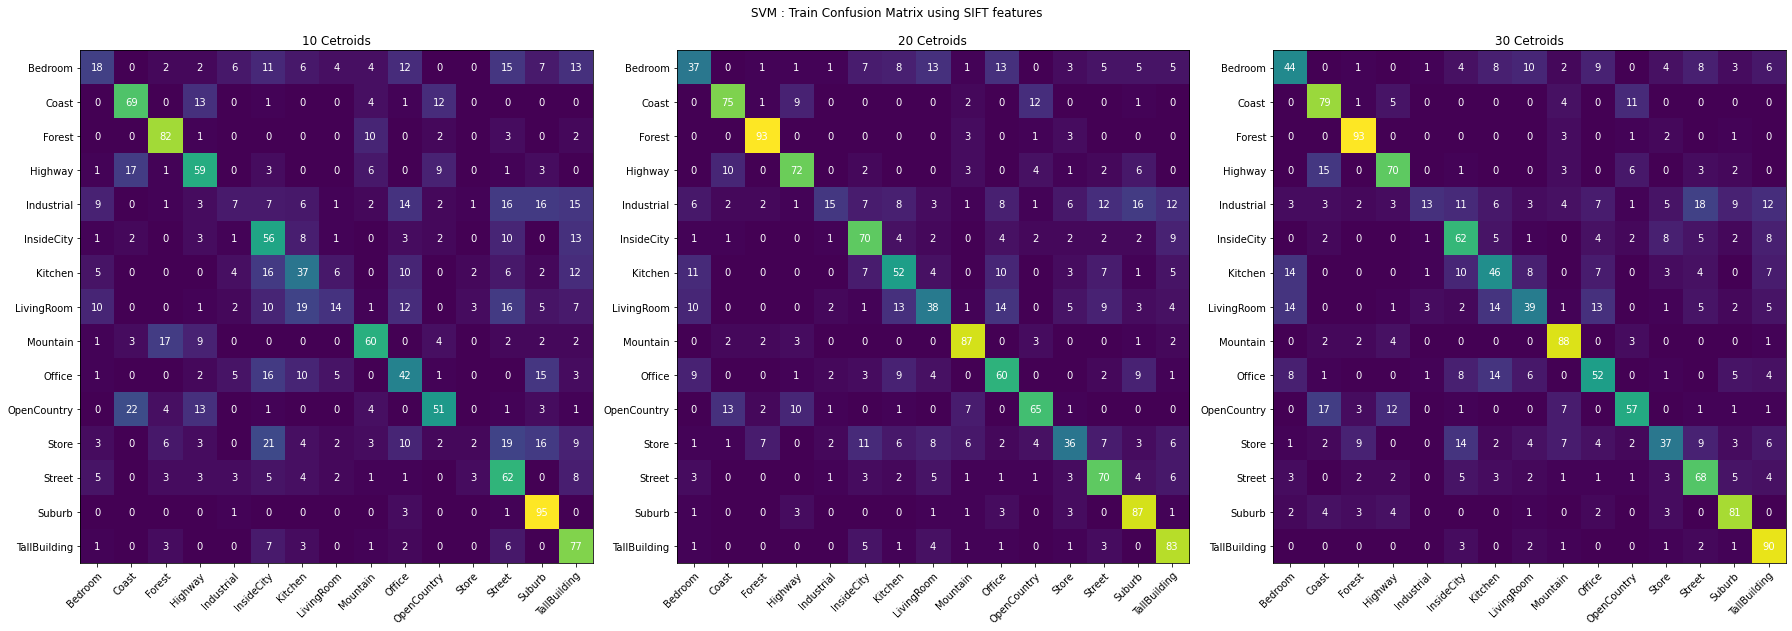

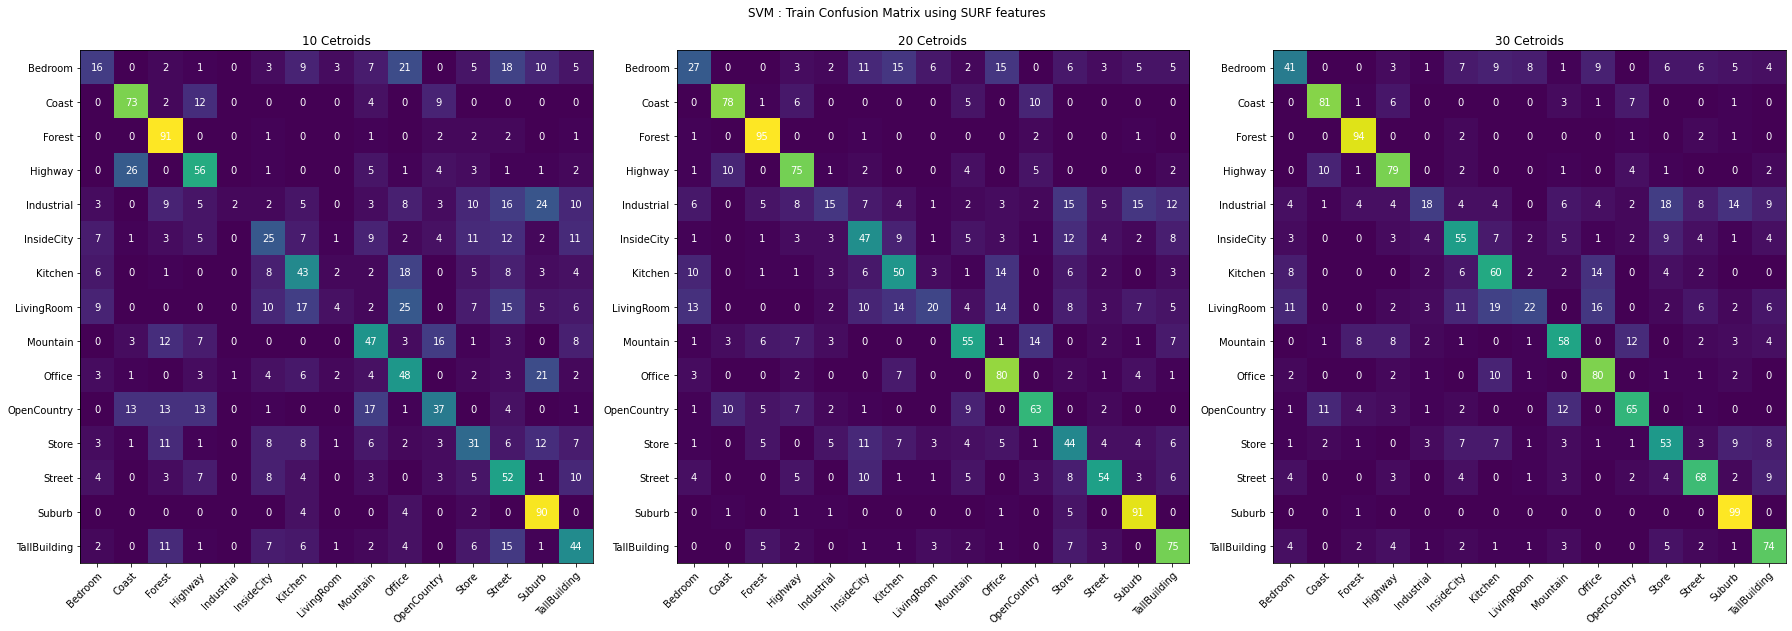

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

SIFT8_c10_svm_pred = SIFT8_c10_svm.predict(SIFT8_c10_train_encoded_features)
SIFT8_c10_svm_train_conf = confusion_matrix(y_train, SIFT8_c10_svm_pred)

SIFT8_c20_svm_pred = SIFT8_c20_svm.predict(SIFT8_c20_train_encoded_features)
SIFT8_c20_svm_train_conf = confusion_matrix(y_train, SIFT8_c20_svm_pred)

SIFT8_c30_svm_pred = SIFT8_c30_svm.predict(SIFT8_c30_train_encoded_features)
SIFT8_c30_svm_train_conf = confusion_matrix(y_train, SIFT8_c30_svm_pred)

plot_confusion_matrix(SIFT8_c10_svm_train_conf, SIFT8_c20_svm_train_conf, SIFT8_c30_svm_train_conf, "SVM : Train Confusion Matrix using SIFT features")

SURF8_c10_svm_pred = SURF8_c10_svm.predict(SURF8_c10_train_encoded_features)
SURF8_c10_svm_train_conf = confusion_matrix(y_train, SURF8_c10_svm_pred)

SURF8_c20_svm_pred = SURF8_c20_svm.predict(SURF8_c20_train_encoded_features)
SURF8_c20_svm_train_conf = confusion_matrix(y_train, SURF8_c20_svm_pred)

SURF8_c30_svm_pred = SURF8_c30_svm.predict(SURF8_c30_train_encoded_features)
SURF8_c30_svm_train_conf = confusion_matrix(y_train, SURF8_c30_svm_pred)

plot_confusion_matrix(SURF8_c10_svm_train_conf, SURF8_c20_svm_train_conf, SURF8_c30_svm_train_conf, "SVM : Train Confusion Matrix using SURF features")

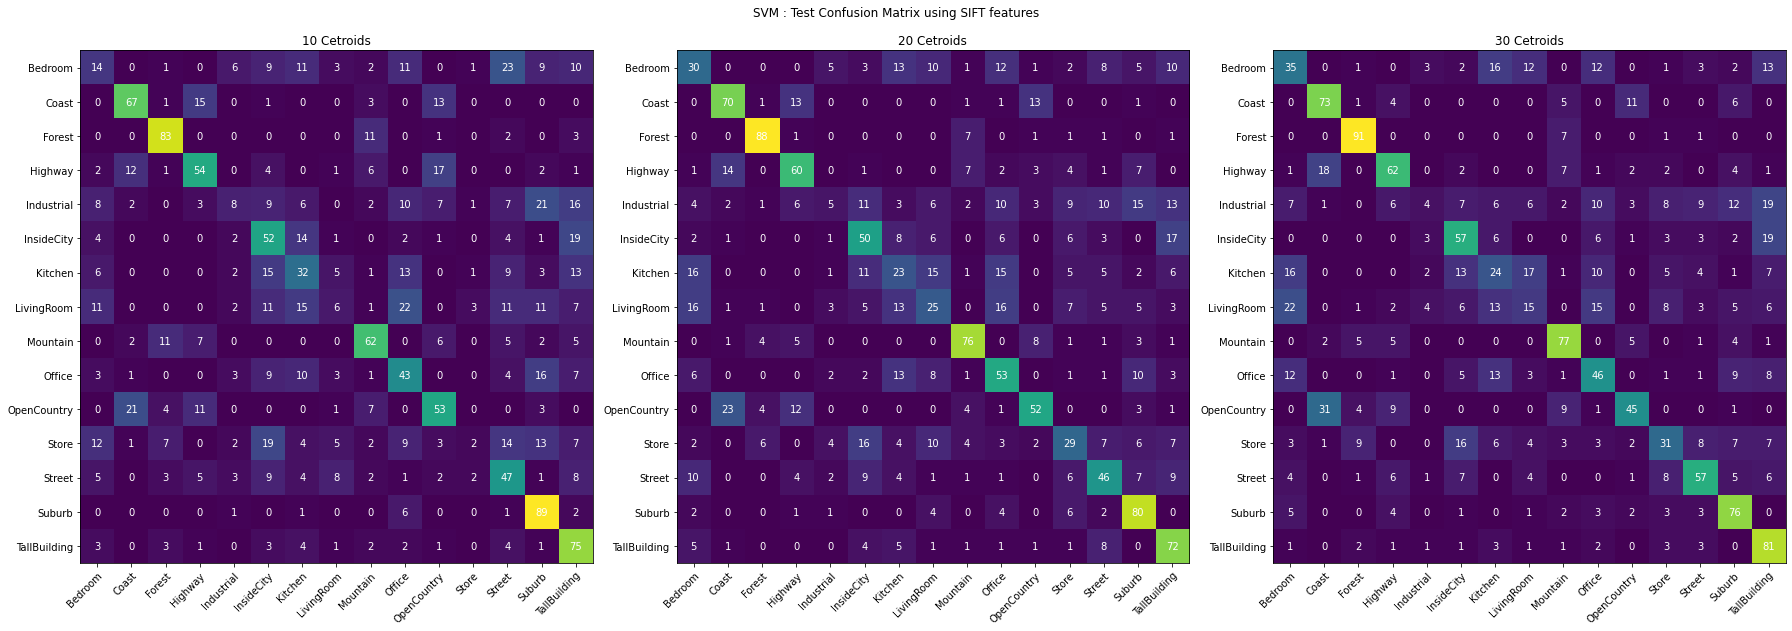

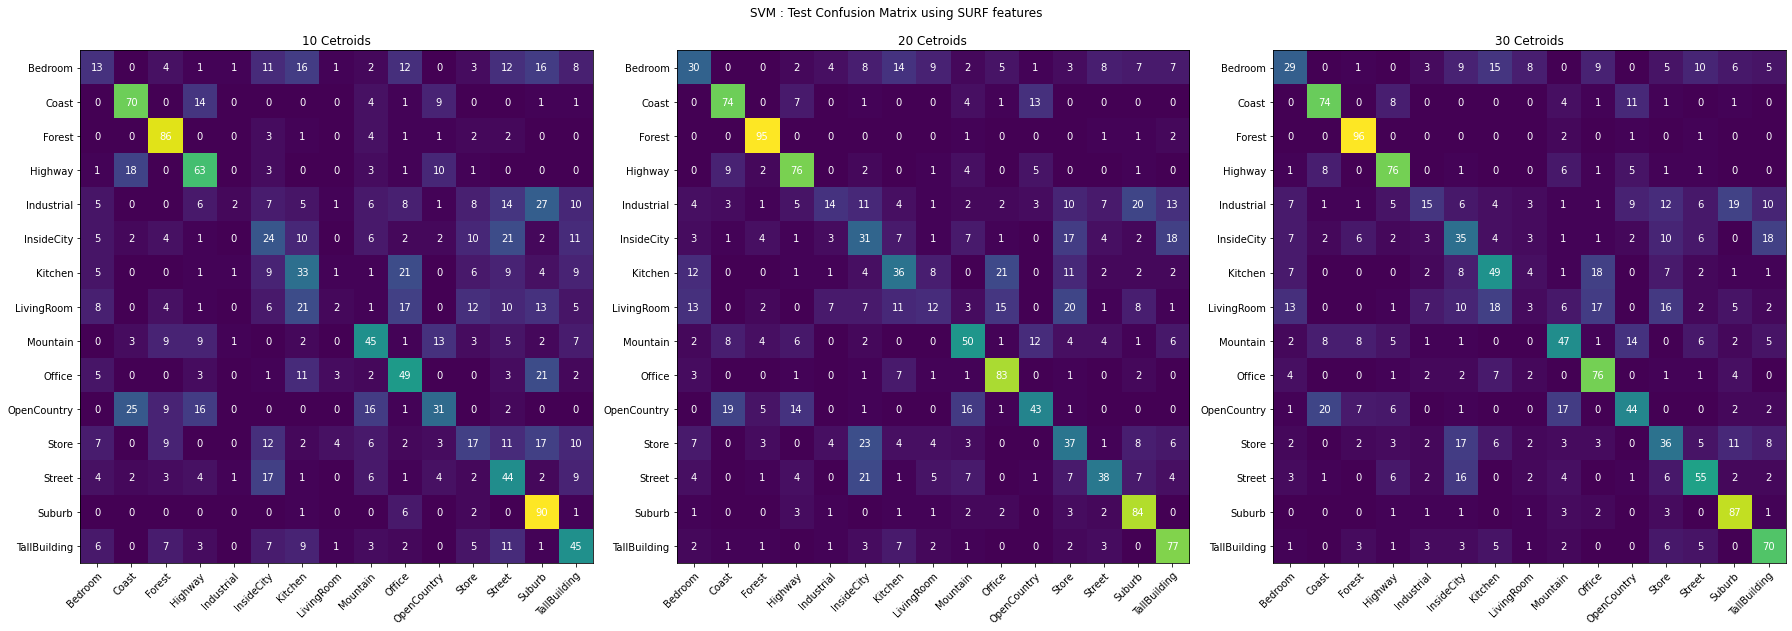

In [ ]:
SIFT8_c10_svm_pred = SIFT8_c10_svm.predict(SIFT8_c10_test_encoded_features)
SIFT8_c10_svm_test_conf = confusion_matrix(y_test, SIFT8_c10_svm_pred)
SIFT8_c20_svm_pred = SIFT8_c20_svm.predict(SIFT8_c20_test_encoded_features)
SIFT8_c20_svm_test_conf = confusion_matrix(y_test, SIFT8_c20_svm_pred)
SIFT8_c30_svm_pred = SIFT8_c30_svm.predict(SIFT8_c30_test_encoded_features)
SIFT8_c30_svm_test_conf = confusion_matrix(y_test, SIFT8_c30_svm_pred)

plot_confusion_matrix(SIFT8_c10_svm_test_conf, SIFT8_c20_svm_test_conf, SIFT8_c30_svm_test_conf, "SVM : Test Confusion Matrix using SIFT features")

SURF8_c10_svm_pred = SURF8_c10_svm.predict(SURF8_c10_test_encoded_features)
SURF8_c10_svm_test_conf = confusion_matrix(y_test, SURF8_c10_svm_pred)
SURF8_c20_svm_pred = SURF8_c20_svm.predict(SURF8_c20_test_encoded_features)
SURF8_c20_svm_test_conf = confusion_matrix(y_test, SURF8_c20_svm_pred)
SURF8_c30_svm_pred = SURF8_c30_svm.predict(SURF8_c30_test_encoded_features)
SURF8_c30_svm_test_conf = confusion_matrix(y_test, SURF8_c30_svm_pred)

plot_confusion_matrix(SURF8_c10_svm_test_conf, SURF8_c20_svm_test_conf, SURF8_c30_svm_test_conf, "SVM : Test Confusion Matrix using SURF features")

In [ ]:
def plot_img(start, end, prediction): 
  f = plt.figure(figsize=(16,16))
  image = np.asarray(x_test)
  for j, image in enumerate(image[start:end]):
    sub = f.add_subplot(1,7, j+1)
    sub.imshow(image, cmap=plt.cm.gray_r, interpolation="none")
    sub.set_title(
      "predict: %i = %s\ntrue: %i = %s"
      % (prediction[start+j], labels_names[prediction[start+j]], y_test[start+j], labels_names[y_test[start+j]]),
      size=10,
    )
    sub.axis("off")
  plt.show()

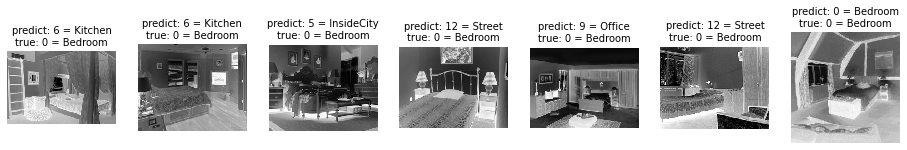

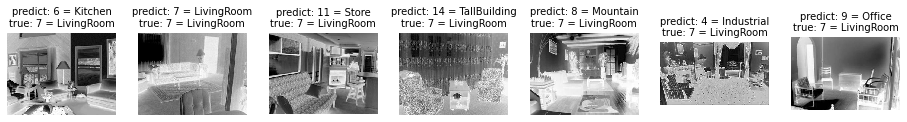

In [ ]:
plot_img(0,7, SURF8_c30_svm_pred)
plot_img(710,717, SURF8_c30_svm_pred)

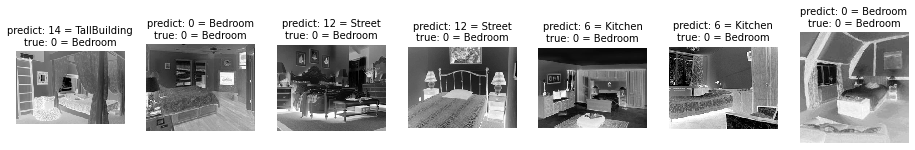

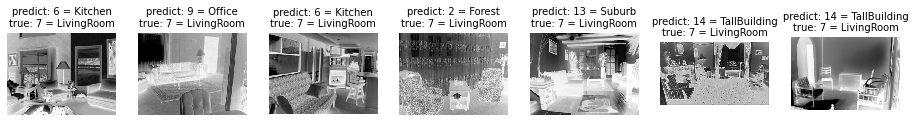

In [ ]:
plot_img(0,7, SIFT8_c30_svm_pred)
plot_img(710,717, SIFT8_c30_svm_pred)

# Classify Images with KNN

In [ ]:
# Write Your Code Here ############################################################
knn = KNeighborsClassifier()
knn_param = {'n_neighbors':(3,9,11,13,15,17,19,21,23,25,27,29,
                            31,33,35,37,39,41,43,45,47,49,51)}
knn_grid = GridSearchCV(knn, knn_param, n_jobs=-1, cv=3)

print("=" * 30, "Model : KNN", "=" * 30)
print("10 Centroids")
SIFT8_c10_knn, SIFT8_c10_knn_df = model_training(knn_grid, SIFT8_c10_train_encoded_features, SIFT8_c10_test_encoded_features)
SIFT8_c10_knn_df.to_csv("SIFT8_c10_KNN_df.csv")
SURF8_c10_knn, SURF8_c10_knn_df = model_training(knn_grid, SURF8_c10_train_encoded_features, SURF8_c10_test_encoded_features)
SURF8_c10_knn_df.to_csv("SURF8_c10_KNN_df.csv")

print("20 Centroids")
SIFT8_c20_knn, SIFT8_c20_knn_df = model_training(knn_grid, SIFT8_c20_train_encoded_features, SIFT8_c20_test_encoded_features)
SIFT8_c20_knn_df.to_csv("SIFT8_c20_KNN_df.csv")
SURF8_c20_knn, SURF8_c20_knn_df = model_training(knn_grid, SURF8_c20_train_encoded_features, SURF8_c20_test_encoded_features)
SURF8_c20_knn_df.to_csv("SURF8_c20_KNN_df.csv")

print("30 Centroids")
SIFT8_c30_knn, SIFT8_c30_knn_df = model_training(knn_grid, SIFT8_c30_train_encoded_features, SIFT8_c30_test_encoded_features)
SIFT8_c30_knn_df.to_csv("SIFT8_c30_KNN_df.csv")
SURF8_c30_knn, SURF8_c30_knn_df = model_training(knn_grid, SURF8_c30_train_encoded_features, SURF8_c30_test_encoded_features)
SURF8_c30_knn_df.to_csv("SURF8_c30_KNN_df.csv")

============================== Model : KNN ==============================
10 Centroids
Best Parameters : {'n_neighbors': 39}
Best Score : 0.4446666666666667
Train  Score: 0.47067
Test   Score: 0.44600

Best Parameters : {'n_neighbors': 9}
Best Score : 0.3913333333333333
Train  Score: 0.54400
Test   Score: 0.40933

20 Centroids
Best Parameters : {'n_neighbors': 23}
Best Score : 0.504
Train  Score: 0.54867
Test   Score: 0.49000

Best Parameters : {'n_neighbors': 21}
Best Score : 0.474
Train  Score: 0.55267
Test   Score: 0.47000

30 Centroids
Best Parameters : {'n_neighbors': 17}
Best Score : 0.5
Train  Score: 0.58667
Test   Score: 0.51067

Best Parameters : {'n_neighbors': 21}
Best Score : 0.4686666666666666
Train  Score: 0.54400
Test   Score: 0.47933



# Print Results

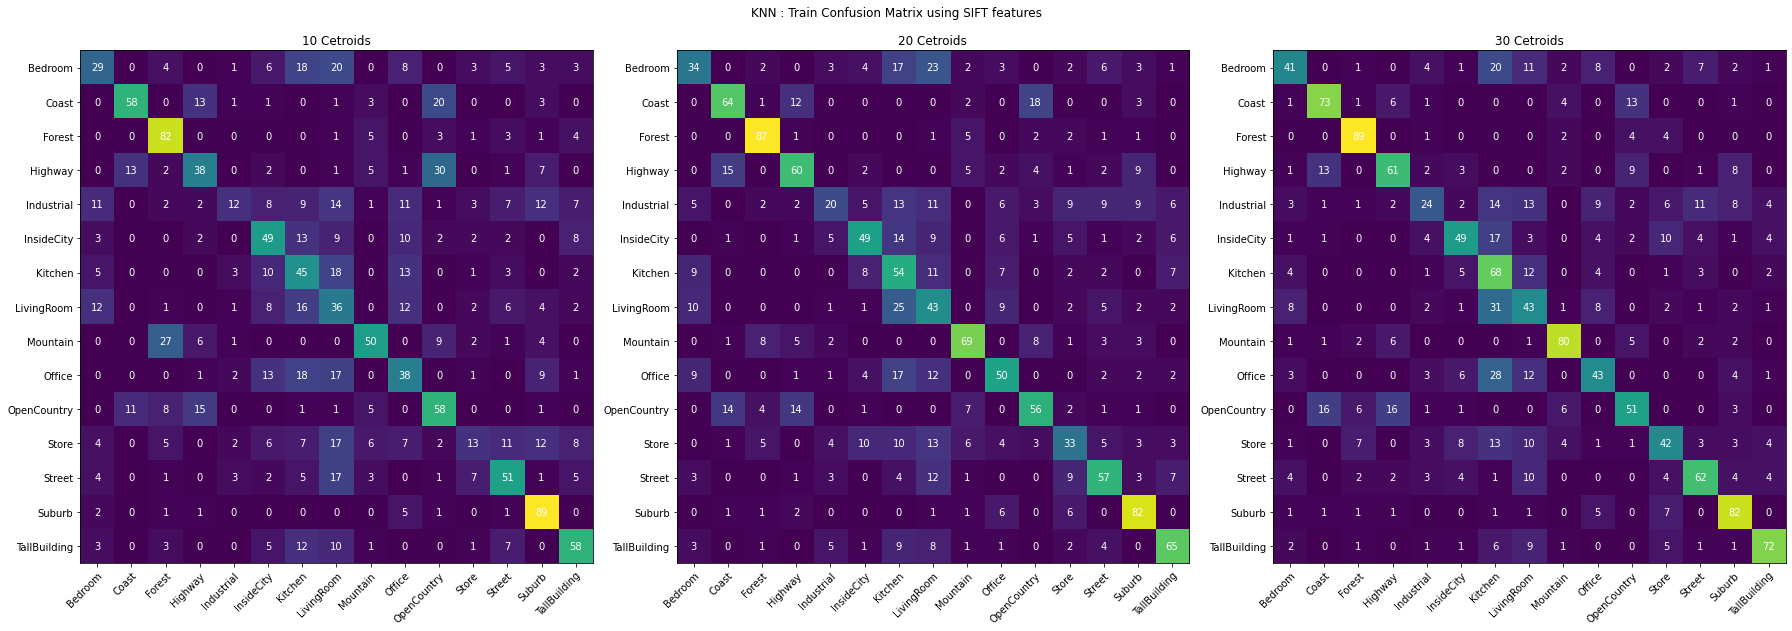

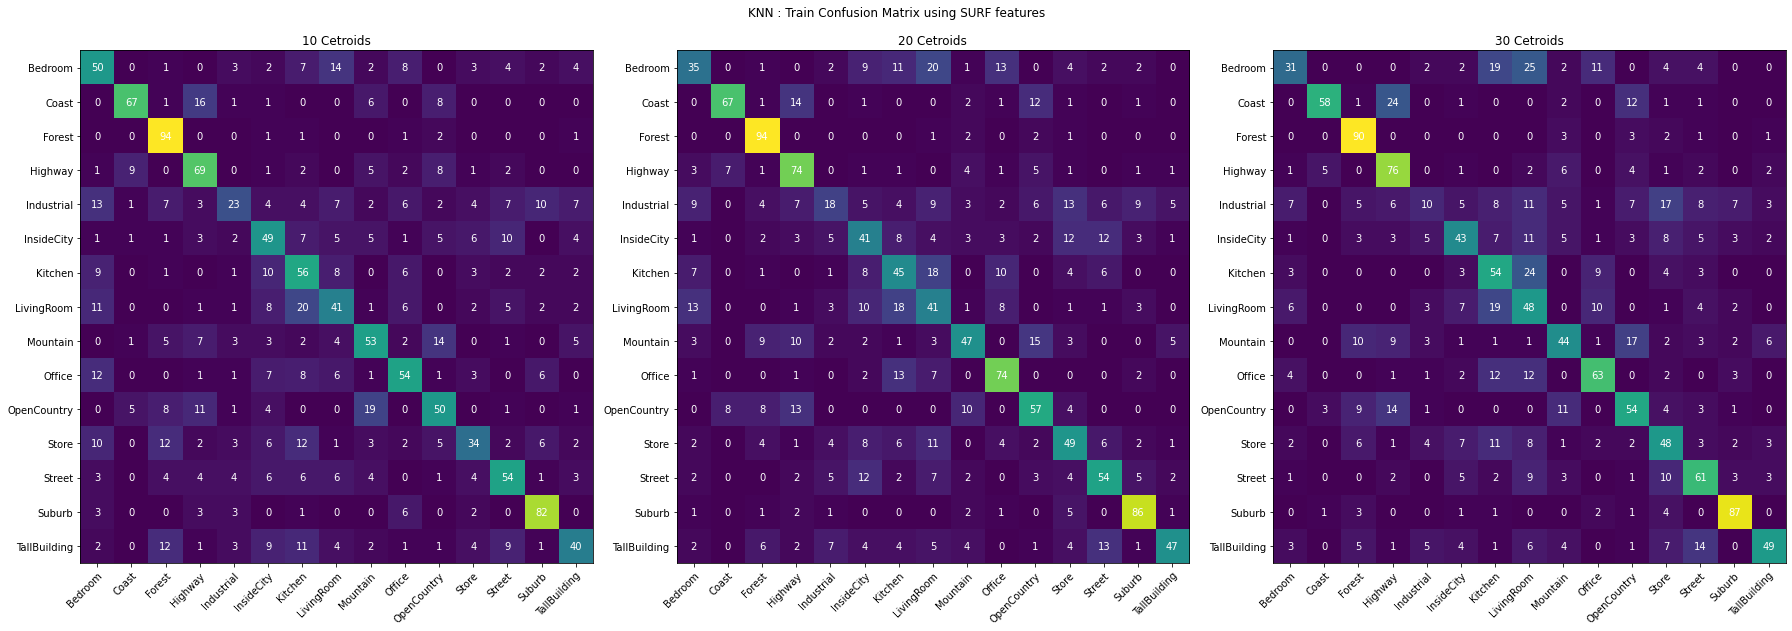

In [ ]:
SIFT8_c10_knn_pred = SIFT8_c10_knn.predict(SIFT8_c10_train_encoded_features)
SIFT8_c10_knn_train_conf = confusion_matrix(y_train, SIFT8_c10_knn_pred)
SIFT8_c20_knn_pred = SIFT8_c20_knn.predict(SIFT8_c20_train_encoded_features)
SIFT8_c20_knn_train_conf = confusion_matrix(y_train, SIFT8_c20_knn_pred)
SIFT8_c30_knn_pred = SIFT8_c30_knn.predict(SIFT8_c30_train_encoded_features)
SIFT8_c30_knn_train_conf = confusion_matrix(y_train, SIFT8_c30_knn_pred)

plot_confusion_matrix(SIFT8_c10_knn_train_conf, SIFT8_c20_knn_train_conf, SIFT8_c30_knn_train_conf, "KNN : Train Confusion Matrix using SIFT features")

SURF8_c10_knn_pred = SURF8_c10_knn.predict(SURF8_c10_train_encoded_features)
SURF8_c10_knn_train_conf = confusion_matrix(y_train, SURF8_c10_knn_pred)
SURF8_c20_knn_pred = SURF8_c20_knn.predict(SURF8_c20_train_encoded_features)
SURF8_c20_knn_train_conf = confusion_matrix(y_train, SURF8_c20_knn_pred)
SURF8_c30_knn_pred = SURF8_c30_knn.predict(SURF8_c30_train_encoded_features)
SURF8_c30_knn_train_conf = confusion_matrix(y_train, SURF8_c30_knn_pred)

plot_confusion_matrix(SURF8_c10_knn_train_conf, SURF8_c20_knn_train_conf, SURF8_c30_knn_train_conf, "KNN : Train Confusion Matrix using SURF features")

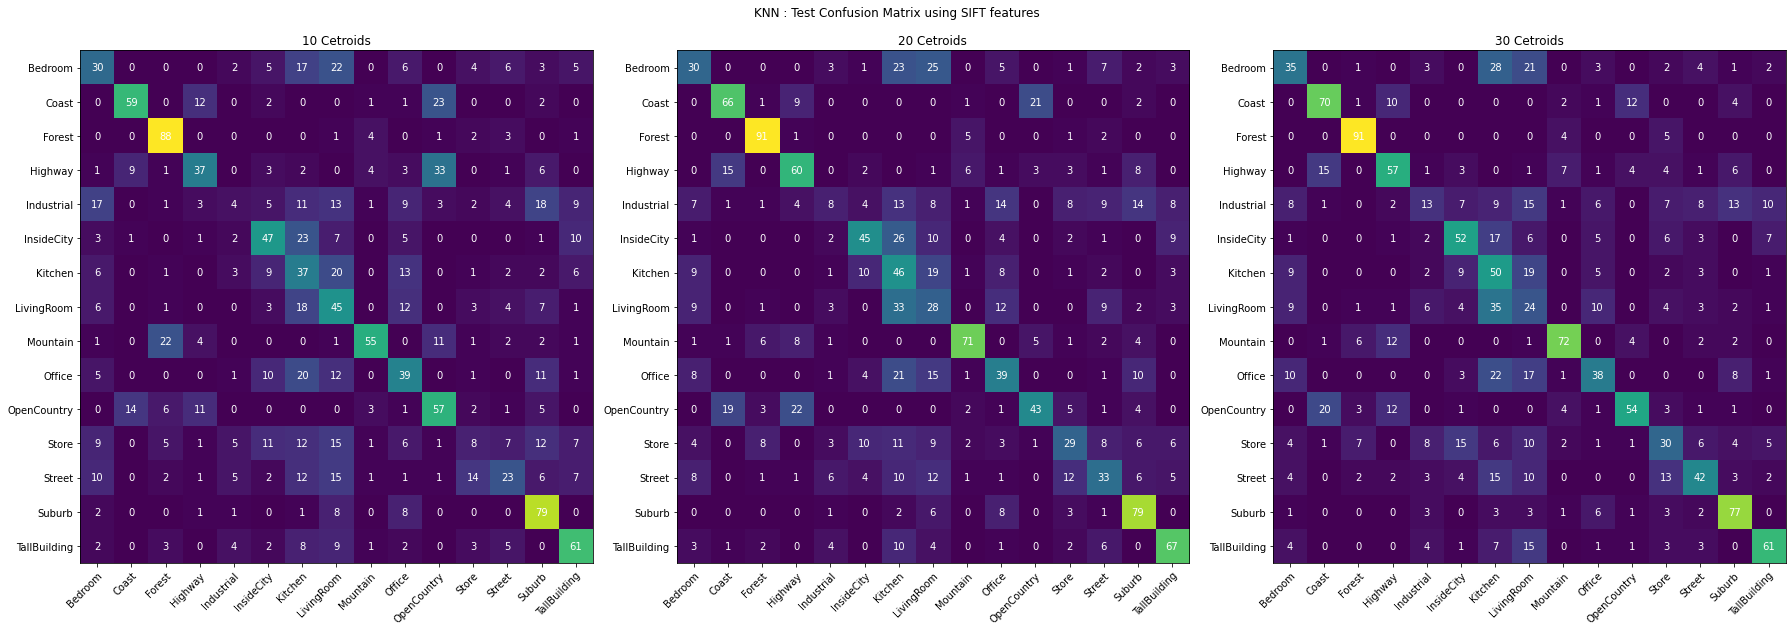

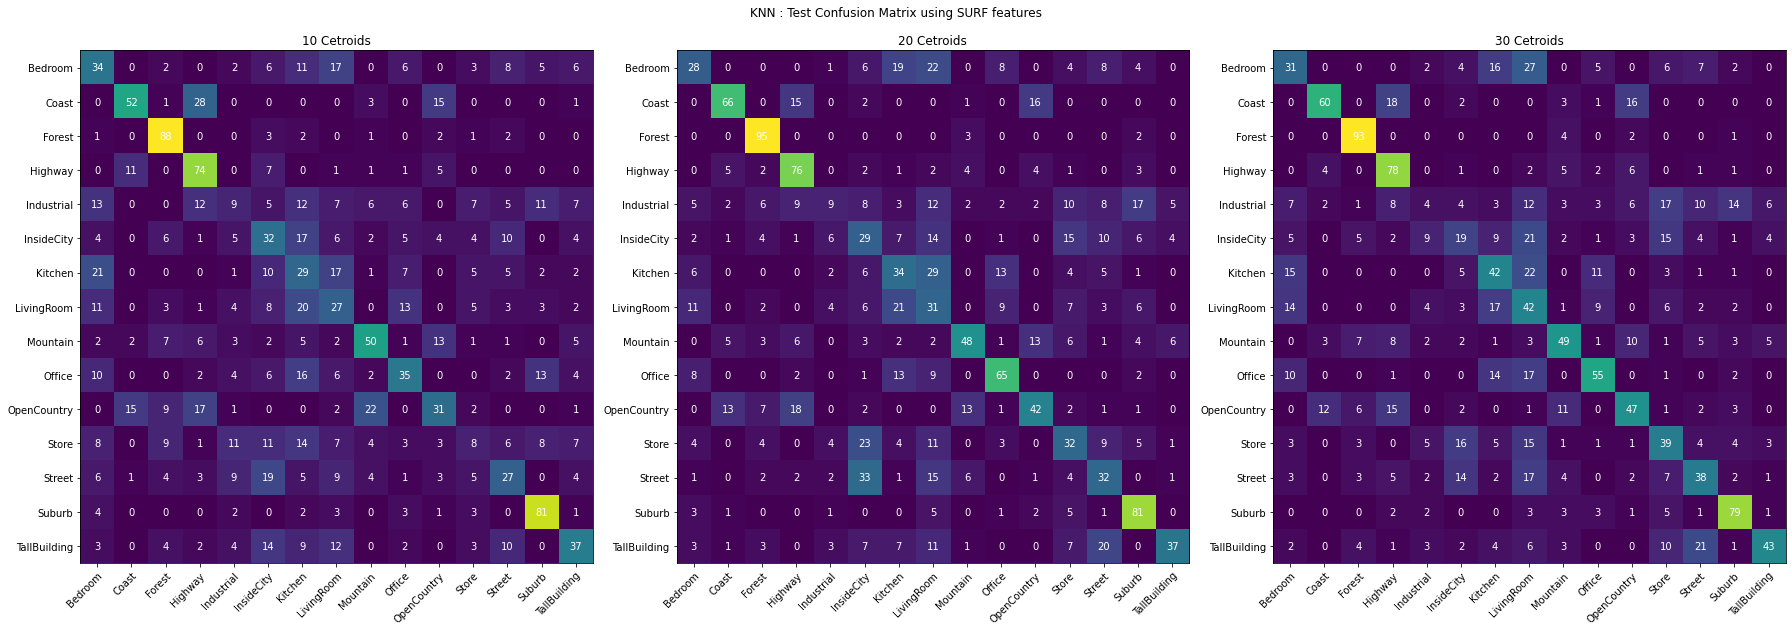

In [ ]:
SIFT8_c10_knn_pred = SIFT8_c10_knn.predict(SIFT8_c10_test_encoded_features)
SIFT8_c10_knn_test_conf = confusion_matrix(y_test, SIFT8_c10_knn_pred)
SIFT8_c20_knn_pred = SIFT8_c20_knn.predict(SIFT8_c20_test_encoded_features)
SIFT8_c20_knn_test_conf = confusion_matrix(y_test, SIFT8_c20_knn_pred)
SIFT8_c30_knn_pred = SIFT8_c30_knn.predict(SIFT8_c30_test_encoded_features)
SIFT8_c30_knn_test_conf = confusion_matrix(y_test, SIFT8_c30_knn_pred)

plot_confusion_matrix(SIFT8_c10_knn_test_conf, SIFT8_c20_knn_test_conf, SIFT8_c30_knn_test_conf, "KNN : Test Confusion Matrix using SIFT features")

SURF8_c10_knn_pred = SURF8_c10_knn.predict(SURF8_c10_test_encoded_features)
SURF8_c10_knn_test_conf = confusion_matrix(y_test, SURF8_c10_knn_pred)
SURF8_c20_knn_pred = SURF8_c20_knn.predict(SURF8_c20_test_encoded_features)
SURF8_c20_knn_test_conf = confusion_matrix(y_test, SURF8_c20_knn_pred)
SURF8_c30_knn_pred = SURF8_c30_knn.predict(SURF8_c30_test_encoded_features)
SURF8_c30_knn_test_conf = confusion_matrix(y_test, SURF8_c30_knn_pred)

plot_confusion_matrix(SURF8_c10_knn_test_conf, SURF8_c20_knn_test_conf, SURF8_c30_knn_test_conf, "KNN : Test Confusion Matrix using SURF features")

# Classify Image with Navie Bayes

In [ ]:
# Write Your Code Here ############################################################

nb = GaussianNB()
nb_param = {"var_smoothing":(1e-9, 1e-5, 1e-3, 1e-1,1e-0)}
nb_grid = GridSearchCV(nb, nb_param, n_jobs=-1, cv=3)

print("=" * 30, "Model : Navie Bayes", "=" * 30)
print("10 Centroids")
SIFT8_c10_nb, SIFT8_c10_nb_df = model_training(nb_grid, SIFT8_c10_train_encoded_features, SIFT8_c10_test_encoded_features)
SIFT8_c10_nb_df.to_csv("SIFT8_c10_NB_df.csv")
SURF8_c10_nb, SURF8_c10_nb_df = model_training(nb_grid, SURF8_c10_train_encoded_features, SURF8_c10_test_encoded_features)
SURF8_c10_nb_df.to_csv("SURF8_c10_NB_df.csv")

print("20 Centroids")
SIFT8_c20_nb, SIFT8_c20_nb_df = model_training(nb_grid, SIFT8_c20_train_encoded_features, SIFT8_c20_test_encoded_features)
SIFT8_c20_nb_df.to_csv("SIFT8_c20_NB_df.csv")
SURF8_c20_nb, SURF8_c20_nb_df = model_training(nb_grid, SURF8_c20_train_encoded_features, SURF8_c20_test_encoded_features)
SURF8_c20_nb_df.to_csv("SURF8_c20_NB_df.csv")

print("30 Centroids")
SIFT8_c30_nb, SIFT8_c30_nb_df = model_training(nb_grid, SIFT8_c30_train_encoded_features, SIFT8_c30_test_encoded_features)
SIFT8_c30_nb_df.to_csv("SIFT8_c30_NB_df.csv")
SURF8_c30_nb, SURF8_c30_nb_df = model_training(nb_grid, SURF8_c30_train_encoded_features, SURF8_c30_test_encoded_features)
SURF8_c30_nb_df.to_csv("SURF8_c30_NB_df.csv")

============================== Model : Navie Bayes ==============================
10 Centroids
Best Parameters : {'var_smoothing': 0.1}
Best Score : 0.4086666666666667
Train  Score: 0.42667
Test   Score: 0.41600

Best Parameters : {'var_smoothing': 0.1}
Best Score : 0.37733333333333335
Train  Score: 0.39667
Test   Score: 0.38400

20 Centroids
Best Parameters : {'var_smoothing': 0.1}
Best Score : 0.46799999999999997
Train  Score: 0.49800
Test   Score: 0.47667

Best Parameters : {'var_smoothing': 0.1}
Best Score : 0.456
Train  Score: 0.48933
Test   Score: 0.48067

30 Centroids
Best Parameters : {'var_smoothing': 0.1}
Best Score : 0.48333333333333334
Train  Score: 0.52000
Test   Score: 0.49333

Best Parameters : {'var_smoothing': 0.1}
Best Score : 0.4686666666666666
Train  Score: 0.49867
Test   Score: 0.46067



# Print Results

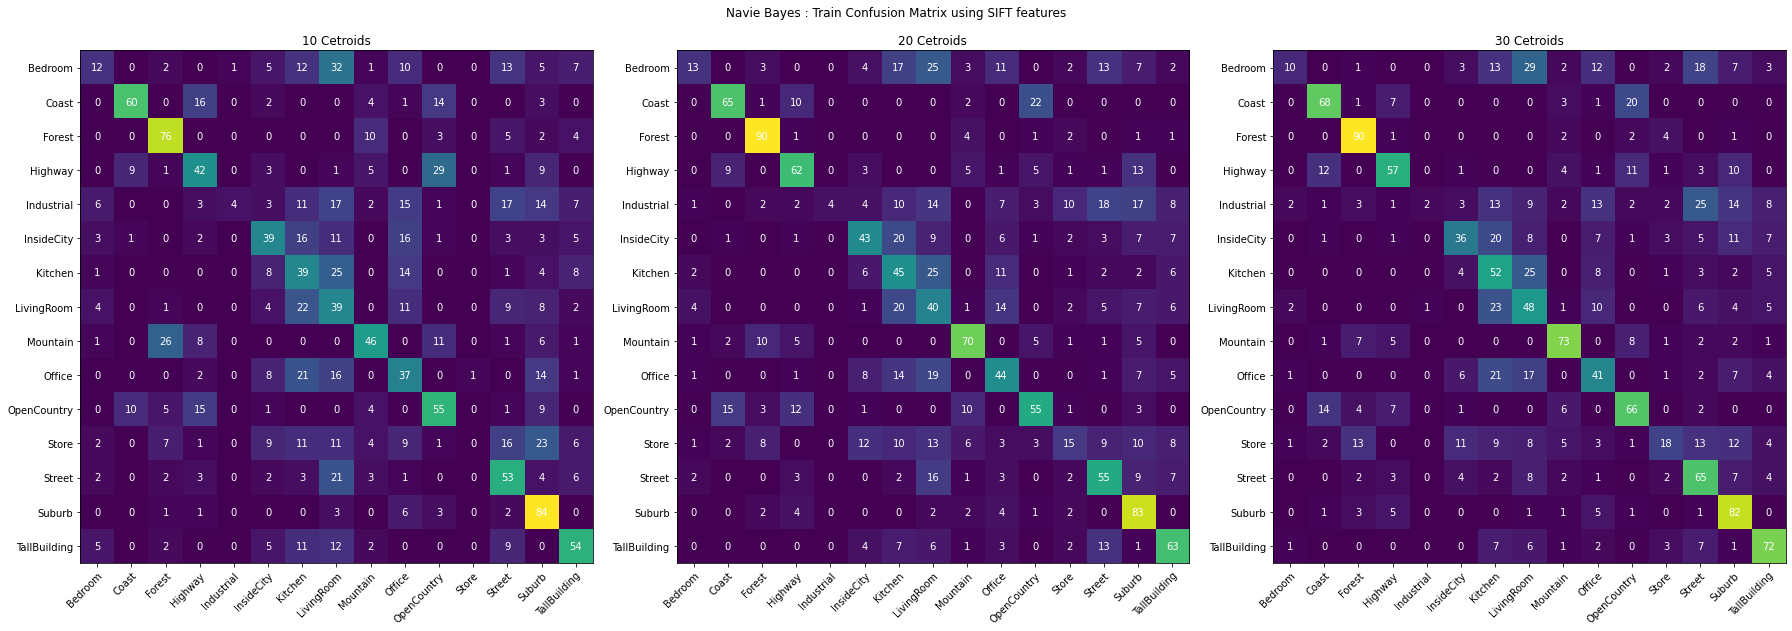

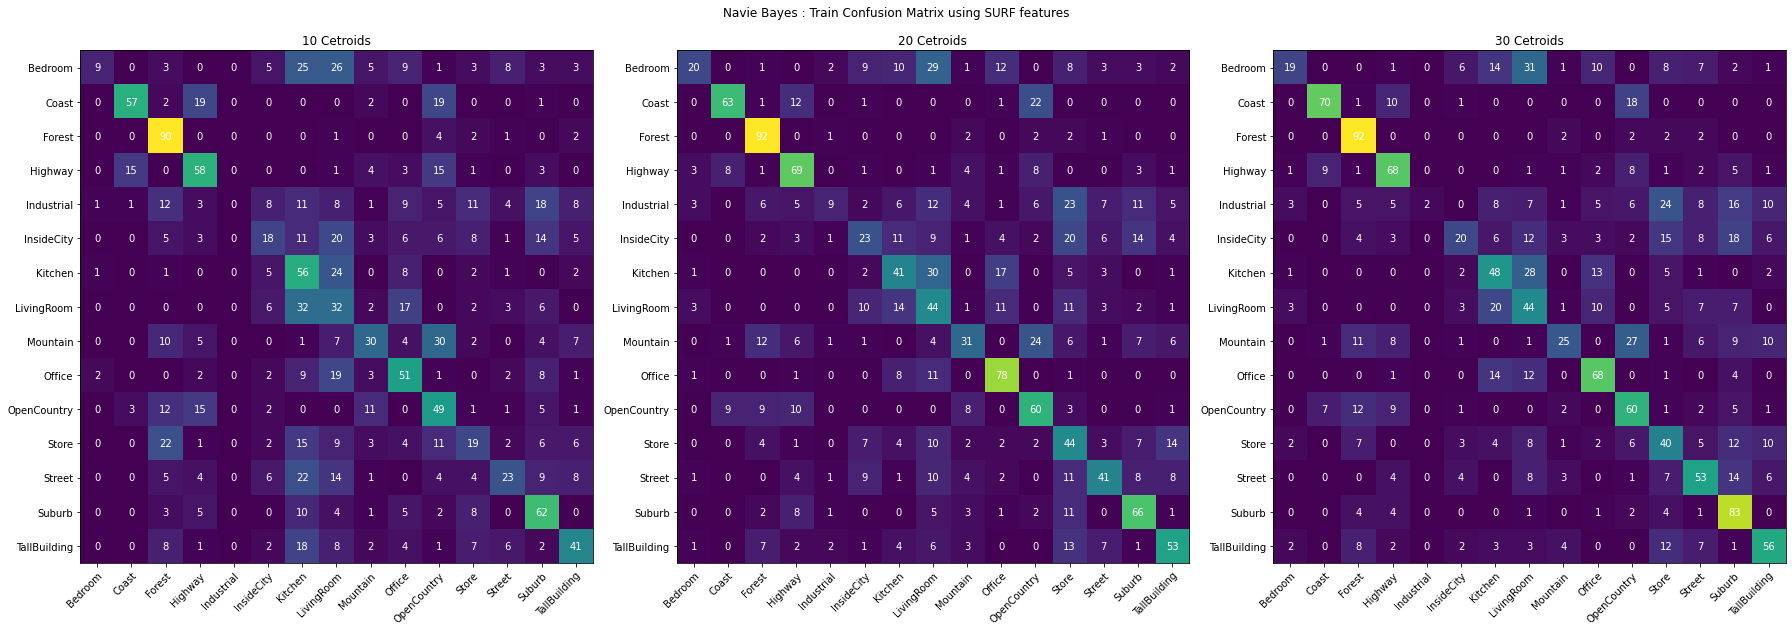

In [ ]:
SIFT8_c10_nb_pred = SIFT8_c10_nb.predict(SIFT8_c10_train_encoded_features)
SIFT8_c10_nb_train_conf = confusion_matrix(y_train, SIFT8_c10_nb_pred)
SIFT8_c20_nb_pred = SIFT8_c20_nb.predict(SIFT8_c20_train_encoded_features)
SIFT8_c20_nb_train_conf = confusion_matrix(y_train, SIFT8_c20_nb_pred)
SIFT8_c30_nb_pred = SIFT8_c30_nb.predict(SIFT8_c30_train_encoded_features)
SIFT8_c30_nb_train_conf = confusion_matrix(y_train, SIFT8_c30_nb_pred)

plot_confusion_matrix(SIFT8_c10_nb_train_conf, SIFT8_c20_nb_train_conf, SIFT8_c30_nb_train_conf, "Navie Bayes : Train Confusion Matrix using SIFT features")

SURF8_c10_nb_pred = SURF8_c10_nb.predict(SURF8_c10_train_encoded_features)
SURF8_c10_nb_train_conf = confusion_matrix(y_train, SURF8_c10_nb_pred)
SURF8_c20_nb_pred = SURF8_c20_nb.predict(SURF8_c20_train_encoded_features)
SURF8_c20_nb_train_conf = confusion_matrix(y_train, SURF8_c20_nb_pred)
SURF8_c30_nb_pred = SURF8_c30_nb.predict(SURF8_c30_train_encoded_features)
SURF8_c30_nb_train_conf = confusion_matrix(y_train, SURF8_c30_nb_pred)

plot_confusion_matrix(SURF8_c10_nb_train_conf, SURF8_c20_nb_train_conf, SURF8_c30_nb_train_conf, "Navie Bayes : Train Confusion Matrix using SURF features")

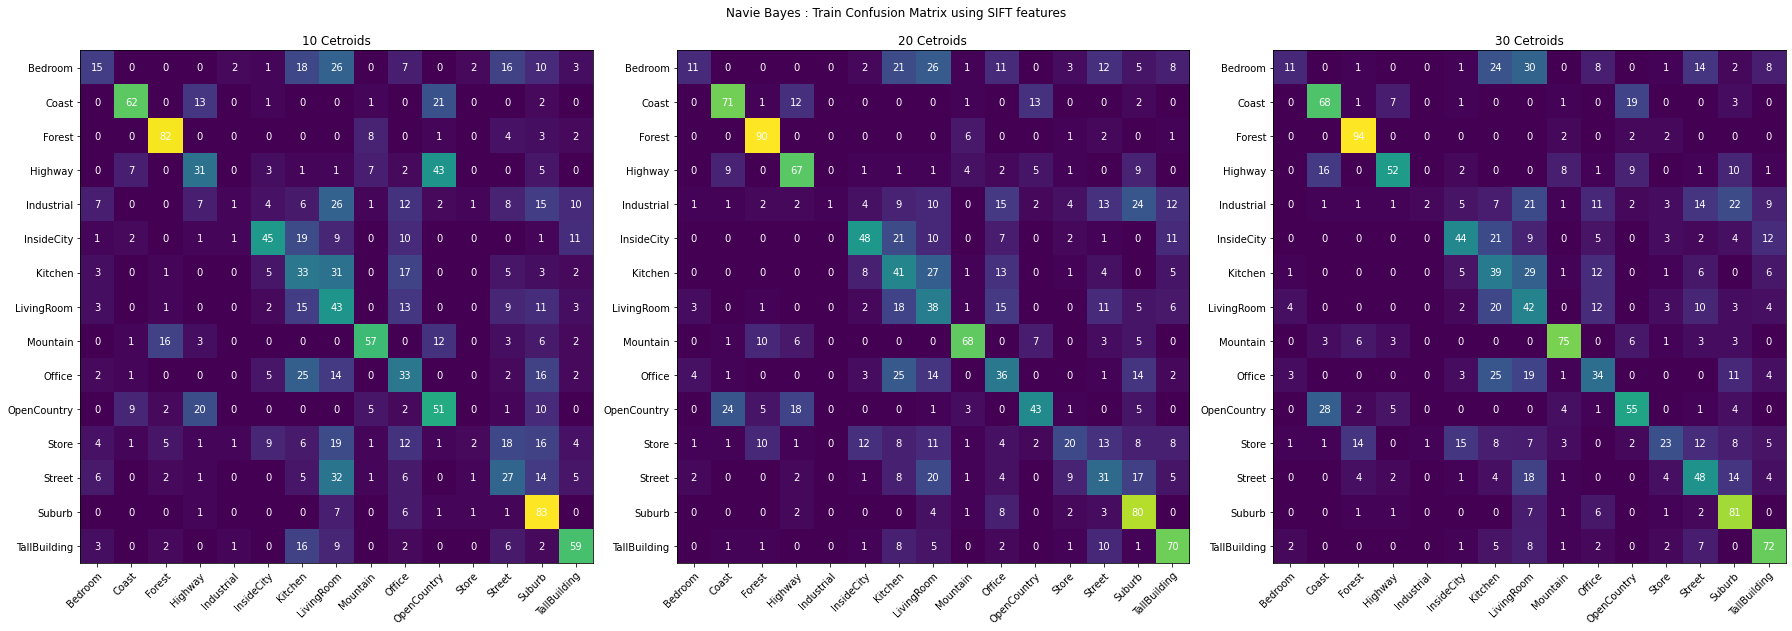

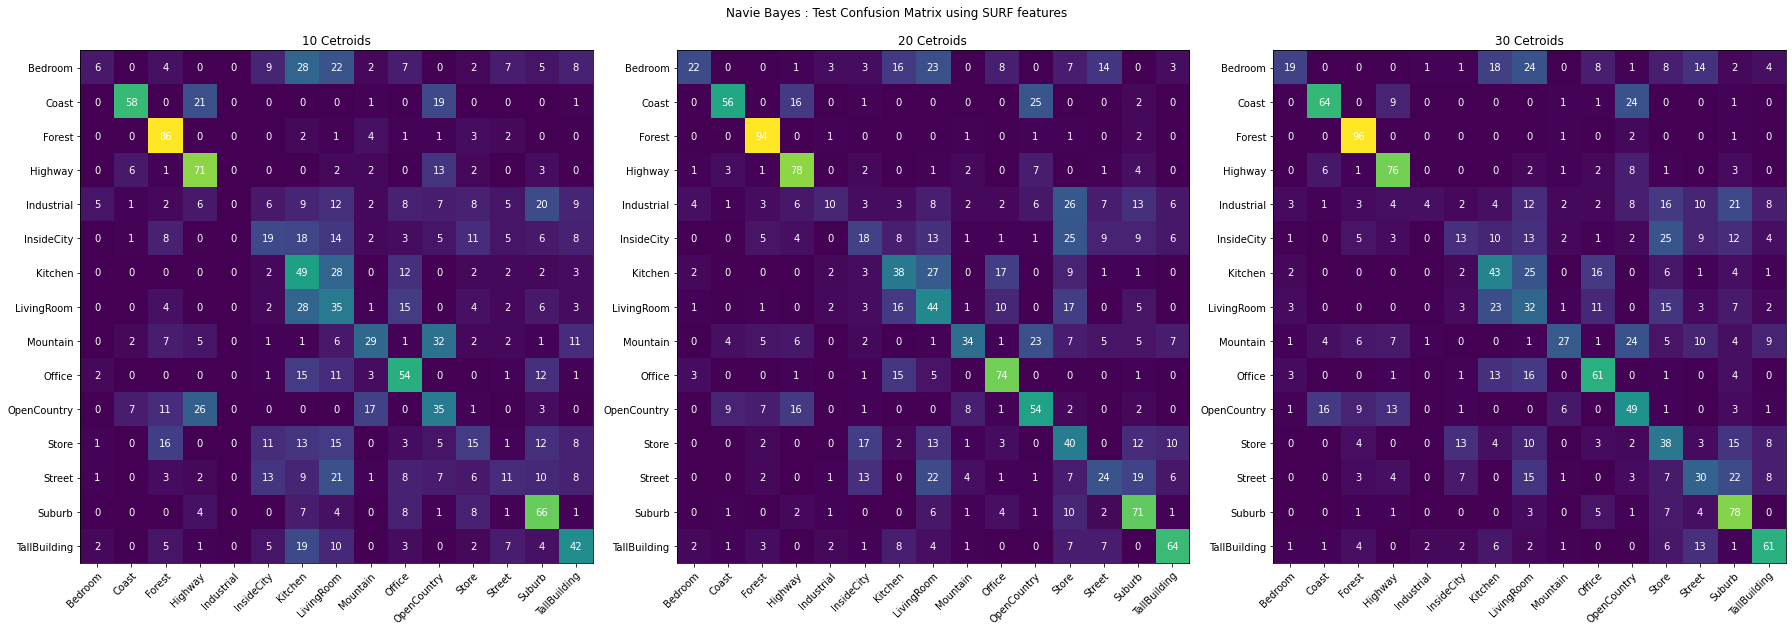

In [ ]:
SIFT8_c10_nb_pred = SIFT8_c10_nb.predict(SIFT8_c10_test_encoded_features)
SIFT8_c10_nb_test_conf = confusion_matrix(y_test, SIFT8_c10_nb_pred)
SIFT8_c20_nb_pred = SIFT8_c20_nb.predict(SIFT8_c20_test_encoded_features)
SIFT8_c20_nb_test_conf = confusion_matrix(y_test, SIFT8_c20_nb_pred)
SIFT8_c30_nb_pred = SIFT8_c30_nb.predict(SIFT8_c30_test_encoded_features)
SIFT8_c30_nb_test_conf = confusion_matrix(y_test, SIFT8_c30_nb_pred)

plot_confusion_matrix(SIFT8_c10_nb_test_conf, SIFT8_c20_nb_test_conf, SIFT8_c30_nb_test_conf, "Navie Bayes : Test Confusion Matrix using SIFT features")

SURF8_c10_nb_pred = SURF8_c10_nb.predict(SURF8_c10_test_encoded_features)
SURF8_c10_nb_test_conf = confusion_matrix(y_test, SURF8_c10_nb_pred)
SURF8_c20_nb_pred = SURF8_c20_nb.predict(SURF8_c20_test_encoded_features)
SURF8_c20_nb_test_conf = confusion_matrix(y_test, SURF8_c20_nb_pred)
SURF8_c30_nb_pred = SURF8_c30_nb.predict(SURF8_c30_test_encoded_features)
SURF8_c30_nb_test_conf = confusion_matrix(y_test, SURF8_c30_nb_pred)

plot_confusion_matrix(SURF8_c10_nb_test_conf, SURF8_c20_nb_test_conf, SURF8_c30_nb_test_conf, "Navie Bayes : Test Confusion Matrix using SURF features")

# Spatial  Pyramid  Matching 

In [ ]:
spatial_SIFT8_c10_train_encoded_features, spatial_SIFT8_c10_test_encoded_features = encoded_features("spatial", SIFT8_codebook10, SIFT8_train_normalized_features, p8_train_feature_shapes, SIFT8_test_normalized_features, p8_test_feature_shapes)
spatial_SURF8_c10_train_encoded_features, spatial_SURF8_c10_test_encoded_features = encoded_features("spatial", SURF8_codebook10, SURF8_train_normalized_features, p8_train_feature_shapes, SURF8_test_normalized_features, p8_test_feature_shapes)

Encoding Train Features ...  100/1500
Encoding Train Features ...  200/1500
Encoding Train Features ...  300/1500
Encoding Train Features ...  400/1500
Encoding Train Features ...  500/1500
Encoding Train Features ...  600/1500
Encoding Train Features ...  700/1500
Encoding Train Features ...  800/1500
Encoding Train Features ...  900/1500
Encoding Train Features ... 1000/1500
Encoding Train Features ... 1100/1500
Encoding Train Features ... 1200/1500
Encoding Train Features ... 1300/1500
Encoding Train Features ... 1400/1500
Encoding Train Features ... 1500/1500
Encoding Test Features ...  100/1500
Encoding Test Features ...  200/1500
Encoding Test Features ...  300/1500
Encoding Test Features ...  400/1500
Encoding Test Features ...  500/1500
Encoding Test Features ...  600/1500
Encoding Test Features ...  700/1500
Encoding Test Features ...  800/1500
Encoding Test Features ...  900/1500
Encoding Test Features ... 1000/1500
Encoding Test Features ... 1100/1500
Encoding Test Features 

In [ ]:
spatial_SIFT8_c10_train_encoded_features, spatial_SIFT8_c10_test_encoded_features = kernel(spatial_SIFT8_c10_train_encoded_features, spatial_SIFT8_c10_test_encoded_features)
spatial_SURF8_c10_train_encoded_features, spatial_SURF8_c10_test_encoded_features = kernel(spatial_SURF8_c10_train_encoded_features, spatial_SURF8_c10_test_encoded_features)

In [ ]:
spatial_SIFT8_c20_train_encoded_features, spatial_SIFT8_c20_test_encoded_features = encoded_features("spatial", SIFT8_codebook20, SIFT8_train_normalized_features, p8_train_feature_shapes, SIFT8_test_normalized_features, p8_test_feature_shapes)
spatial_SURF8_c20_train_encoded_features, spatial_SURF8_c20_test_encoded_features = encoded_features("spatial", SURF8_codebook20, SURF8_train_normalized_features, p8_train_feature_shapes, SURF8_test_normalized_features, p8_test_feature_shapes)

Encoding Train Features ...  100/1500
Encoding Train Features ...  200/1500
Encoding Train Features ...  300/1500
Encoding Train Features ...  400/1500
Encoding Train Features ...  500/1500
Encoding Train Features ...  600/1500
Encoding Train Features ...  700/1500
Encoding Train Features ...  800/1500
Encoding Train Features ...  900/1500
Encoding Train Features ... 1000/1500
Encoding Train Features ... 1100/1500
Encoding Train Features ... 1200/1500
Encoding Train Features ... 1300/1500
Encoding Train Features ... 1400/1500
Encoding Train Features ... 1500/1500
Encoding Test Features ...  100/1500
Encoding Test Features ...  200/1500
Encoding Test Features ...  300/1500
Encoding Test Features ...  400/1500
Encoding Test Features ...  500/1500
Encoding Test Features ...  600/1500
Encoding Test Features ...  700/1500
Encoding Test Features ...  800/1500
Encoding Test Features ...  900/1500
Encoding Test Features ... 1000/1500
Encoding Test Features ... 1100/1500
Encoding Test Features 

In [ ]:
spatial_SIFT8_c20_train_encoded_features, spatial_SIFT8_c20_test_encoded_features = kernel(spatial_SIFT8_c20_train_encoded_features, spatial_SIFT8_c20_test_encoded_features)
spatial_SURF8_c20_train_encoded_features, spatial_SURF8_c20_test_encoded_features = kernel(spatial_SURF8_c20_train_encoded_features, spatial_SURF8_c20_test_encoded_features)

In [ ]:
spatial_SIFT8_c30_train_encoded_features, spatial_SIFT8_c30_test_encoded_features = encoded_features("spatial", SIFT8_codebook30, SIFT8_train_normalized_features, p8_train_feature_shapes, SIFT8_test_normalized_features, p8_test_feature_shapes)
spatial_SURF8_c30_train_encoded_features, spatial_SURF8_c30_test_encoded_features = encoded_features("spatial", SURF8_codebook30, SURF8_train_normalized_features, p8_train_feature_shapes, SURF8_test_normalized_features, p8_test_feature_shapes)

Encoding Train Features ...  100/1500
Encoding Train Features ...  200/1500
Encoding Train Features ...  300/1500
Encoding Train Features ...  400/1500
Encoding Train Features ...  500/1500
Encoding Train Features ...  600/1500
Encoding Train Features ...  700/1500
Encoding Train Features ...  800/1500
Encoding Train Features ...  900/1500
Encoding Train Features ... 1000/1500
Encoding Train Features ... 1100/1500
Encoding Train Features ... 1200/1500
Encoding Train Features ... 1300/1500
Encoding Train Features ... 1400/1500
Encoding Train Features ... 1500/1500
Encoding Test Features ...  100/1500
Encoding Test Features ...  200/1500
Encoding Test Features ...  300/1500
Encoding Test Features ...  400/1500
Encoding Test Features ...  500/1500
Encoding Test Features ...  600/1500
Encoding Test Features ...  700/1500
Encoding Test Features ...  800/1500
Encoding Test Features ...  900/1500
Encoding Test Features ... 1000/1500
Encoding Test Features ... 1100/1500
Encoding Test Features 

In [ ]:
spatial_SIFT8_c30_train_encoded_features, spatial_SIFT8_c30_test_encoded_features = kernel(spatial_SIFT8_c30_train_encoded_features, spatial_SIFT8_c30_test_encoded_features)
spatial_SURF8_c30_train_encoded_features, spatial_SURF8_c30_test_encoded_features = kernel(spatial_SURF8_c30_train_encoded_features, spatial_SURF8_c30_test_encoded_features)

In [ ]:
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings(action='ignore') 

import pandas as pd

svm = LinearSVC()
svm_param = {'C':(0.001, 0.001, 0.01, 0.1, 1, 10, 100),
              'max_iter':(10,100,1000,10000,-1)}
svm_grid = GridSearchCV(svm, svm_param, n_jobs=-1, cv=3)

print("Classify Images ...\n")

print("10 Centroids")
SIFT8_c10_spatial, SIFT8_c10_spatial_df = model_training(svm_grid, spatial_SIFT8_c10_train_encoded_features, spatial_SIFT8_c10_test_encoded_features)
SIFT8_c10_spatial_df.to_csv("SIFT8_c10_spatial_df.csv")
SURF8_c10_spatial, SURF8_c10_spatial_df = model_training(svm_grid, spatial_SURF8_c10_train_encoded_features, spatial_SURF8_c10_test_encoded_features)
SURF8_c10_spatial_df.to_csv("SURF8_c10_spatial_df.csv")

Classify Images ...

10 Centroids
Best Parameters : {'C': 0.001, 'max_iter': 100}
Best Score : 0.6093333333333333
Train  Score: 0.76667
Test   Score: 0.61400

Best Parameters : {'C': 0.01, 'max_iter': 100}
Best Score : 0.622
Train  Score: 0.85200
Test   Score: 0.62000



In [ ]:
print("20 Centroids")
SIFT8_c20_spatial, SIFT8_c20_spatial_df = model_training(svm_grid, spatial_SIFT8_c20_train_encoded_features, spatial_SIFT8_c20_test_encoded_features)
SIFT8_c20_spatial_df.to_csv("SIFT8_c20_spatial_df.csv")
SURF8_c20_spatial, SURF8_c20_spatial_df = model_training(svm_grid, spatial_SURF8_c20_train_encoded_features, spatial_SURF8_c20_test_encoded_features)
SURF8_c20_spatial_df.to_csv("SURF8_c20_spatial_df.csv")

20 Centroids
Best Parameters : {'C': 0.001, 'max_iter': 100}
Best Score : 0.6713333333333334
Train  Score: 0.87200
Test   Score: 0.67400

Best Parameters : {'C': 0.001, 'max_iter': 10}
Best Score : 0.632
Train  Score: 0.79867
Test   Score: 0.64933



In [ ]:
print("30 Centroids")
SIFT8_c30_spatial, SIFT8_c30_spatial_df = model_training(svm_grid, spatial_SIFT8_c30_train_encoded_features, spatial_SIFT8_c30_test_encoded_features)
SIFT8_c30_spatial_df.to_csv("SIFT8_c30_spatial_df.csv")
SURF8_c30_spatial, SURF8_c30_spatial_df = model_training(svm_grid, spatial_SURF8_c30_train_encoded_features, spatial_SURF8_c30_test_encoded_features)
SURF8_c30_spatial_df.to_csv("SURF8_c30_spatial_df.csv")

30 Centroids
Best Parameters : {'C': 0.001, 'max_iter': 10}
Best Score : 0.6686666666666667
Train  Score: 0.90067
Test   Score: 0.67333

Best Parameters : {'C': 0.001, 'max_iter': 100}
Best Score : 0.6706666666666666
Train  Score: 0.87067
Test   Score: 0.67733



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

SIFT8_c10_spatial_pred = SIFT8_c10_spatial.predict(spatial_SIFT8_c10_train_encoded_features)
SIFT8_c10_spatial_train_conf = confusion_matrix(y_train, SIFT8_c10_spatial_pred)
SURF8_c10_spatial_pred = SURF8_c10_spatial.predict(spatial_SURF8_c10_train_encoded_features)
SURF8_c10_spatial_train_conf = confusion_matrix(y_train, SURF8_c10_spatial_pred)

SIFT8_c20_spatial_pred = SIFT8_c20_spatial.predict(spatial_SIFT8_c20_train_encoded_features)
SIFT8_c20_spatial_train_conf = confusion_matrix(y_train, SIFT8_c20_spatial_pred)
SURF8_c20_spatial_pred = SURF8_c20_spatial.predict(spatial_SURF8_c20_train_encoded_features)
SURF8_c20_spatial_train_conf = confusion_matrix(y_train, SURF8_c20_spatial_pred)

SIFT8_c30_spatial_pred = SIFT8_c30_spatial.predict(spatial_SIFT8_c30_train_encoded_features)
SIFT8_c30_spatial_train_conf = confusion_matrix(y_train, SIFT8_c30_spatial_pred)
SURF8_c30_spatial_pred = SURF8_c30_spatial.predict(spatial_SURF8_c30_train_encoded_features)
SURF8_c30_spatial_train_conf = confusion_matrix(y_train, SURF8_c30_spatial_pred)

SIFT8_c10_spatial_pred = SIFT8_c10_spatial.predict(spatial_SIFT8_c10_test_encoded_features)
SIFT8_c10_spatial_test_conf = confusion_matrix(y_test, SIFT8_c10_spatial_pred)
SURF8_c10_spatial_pred = SURF8_c10_spatial.predict(spatial_SURF8_c10_test_encoded_features)
SURF8_c10_spatial_test_conf = confusion_matrix(y_test, SURF8_c10_spatial_pred)

SIFT8_c20_spatial_pred = SIFT8_c20_spatial.predict(spatial_SIFT8_c20_test_encoded_features)
SIFT8_c20_spatial_test_conf = confusion_matrix(y_test, SIFT8_c20_spatial_pred)
SURF8_c20_spatial_pred = SURF8_c20_spatial.predict(spatial_SURF8_c20_test_encoded_features)
SURF8_c20_spatial_test_conf = confusion_matrix(y_test, SURF8_c20_spatial_pred)

SIFT8_c30_spatial_pred = SIFT8_c30_spatial.predict(spatial_SIFT8_c30_test_encoded_features)
SIFT8_c30_spatial_test_conf = confusion_matrix(y_test, SIFT8_c30_spatial_pred)
SURF8_c30_spatial_pred = SURF8_c30_spatial.predict(spatial_SURF8_c30_test_encoded_features)
SURF8_c30_spatial_test_conf = confusion_matrix(y_test, SURF8_c30_spatial_pred)

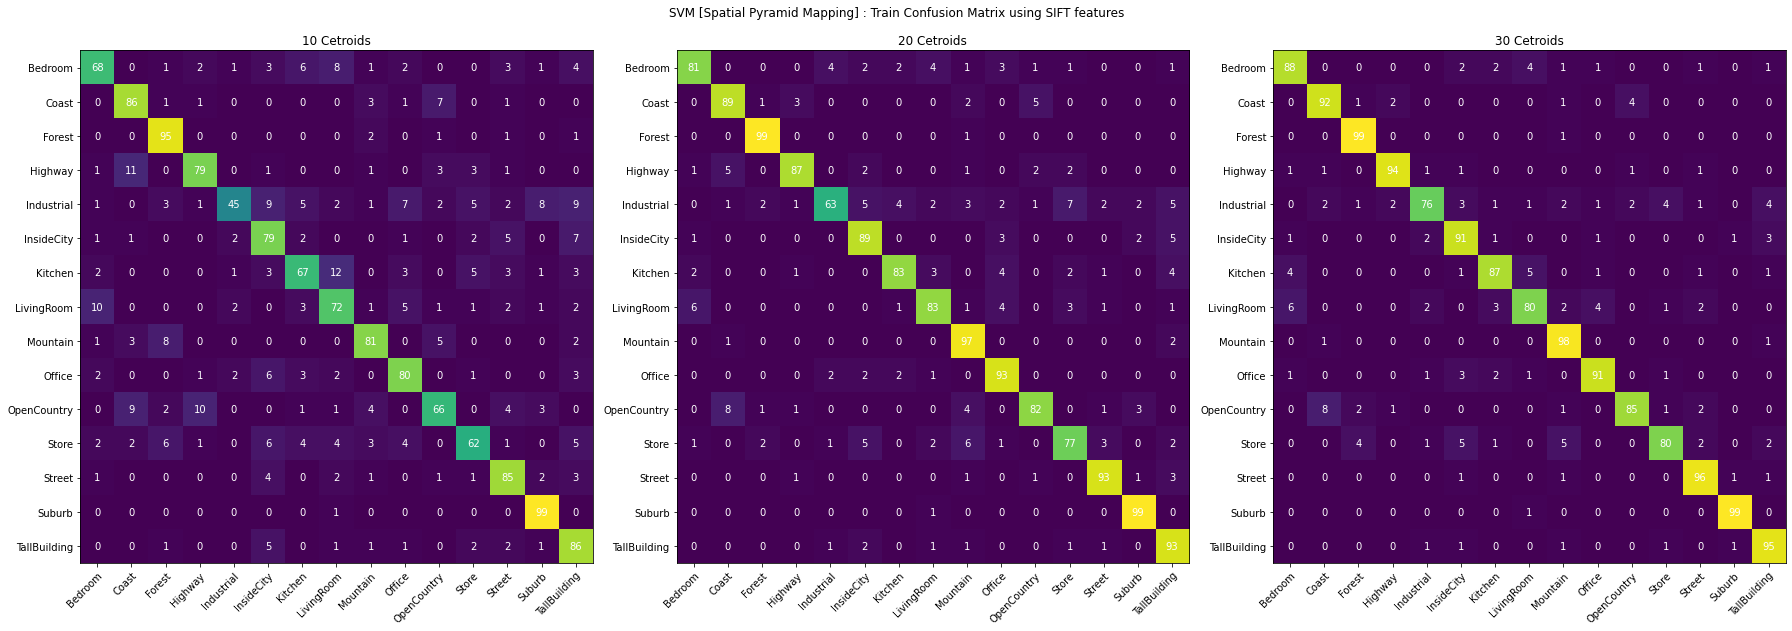

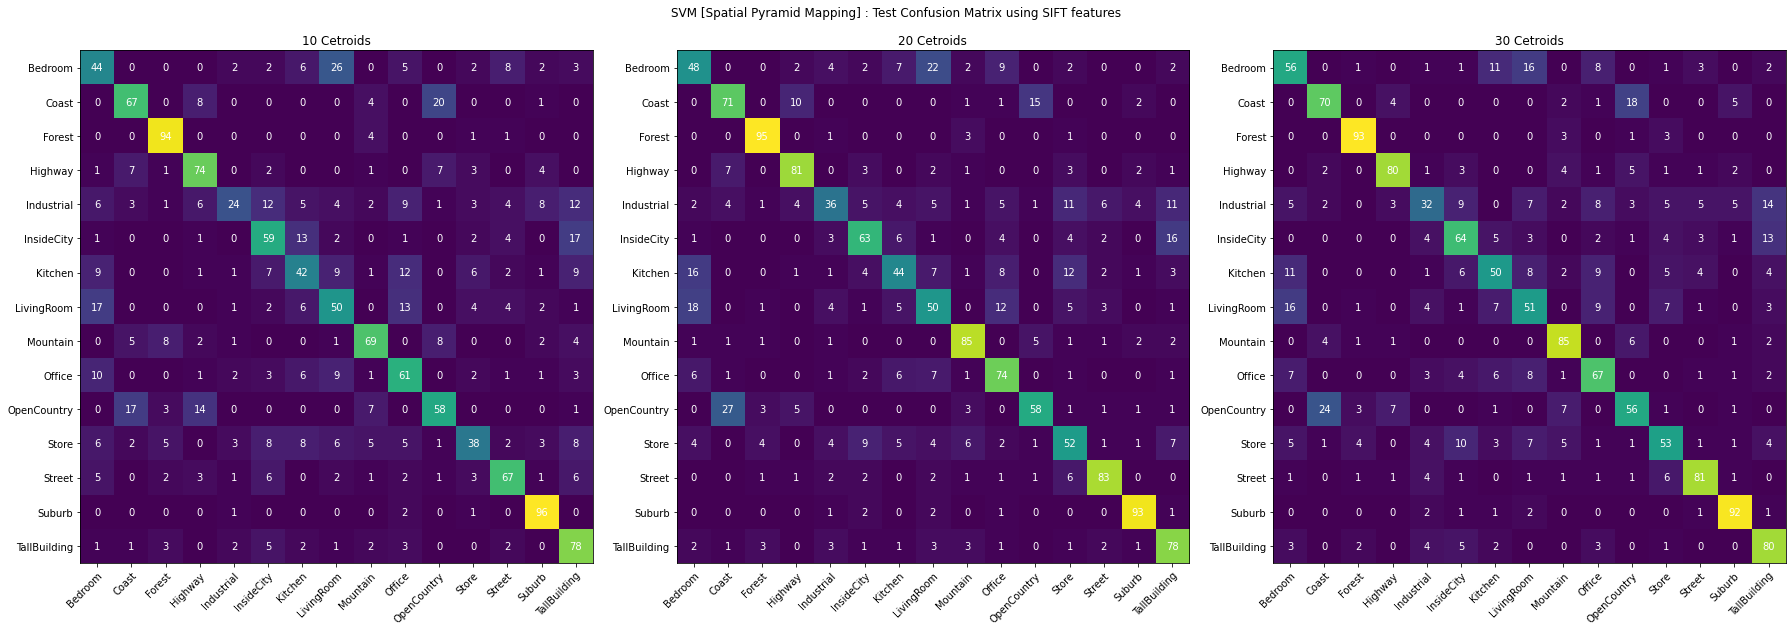

In [ ]:
plot_confusion_matrix(SIFT8_c10_spatial_train_conf, SIFT8_c20_spatial_train_conf, SIFT8_c30_spatial_train_conf, "SVM [Spatial Pyramid Mapping] : Train Confusion Matrix using SIFT features")
plot_confusion_matrix(SIFT8_c10_spatial_test_conf, SIFT8_c20_spatial_test_conf, SIFT8_c30_spatial_test_conf, "SVM [Spatial Pyramid Mapping] : Test Confusion Matrix using SIFT features")

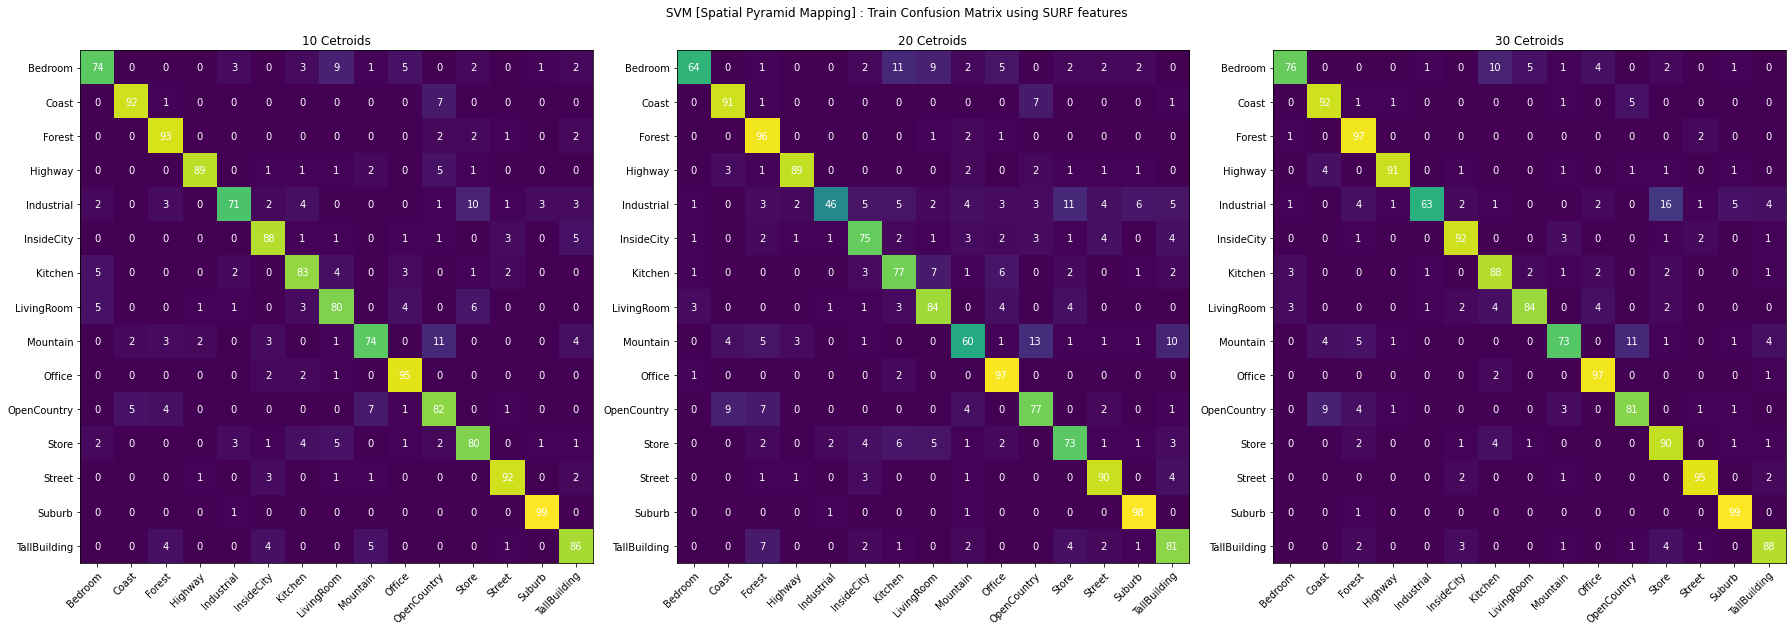

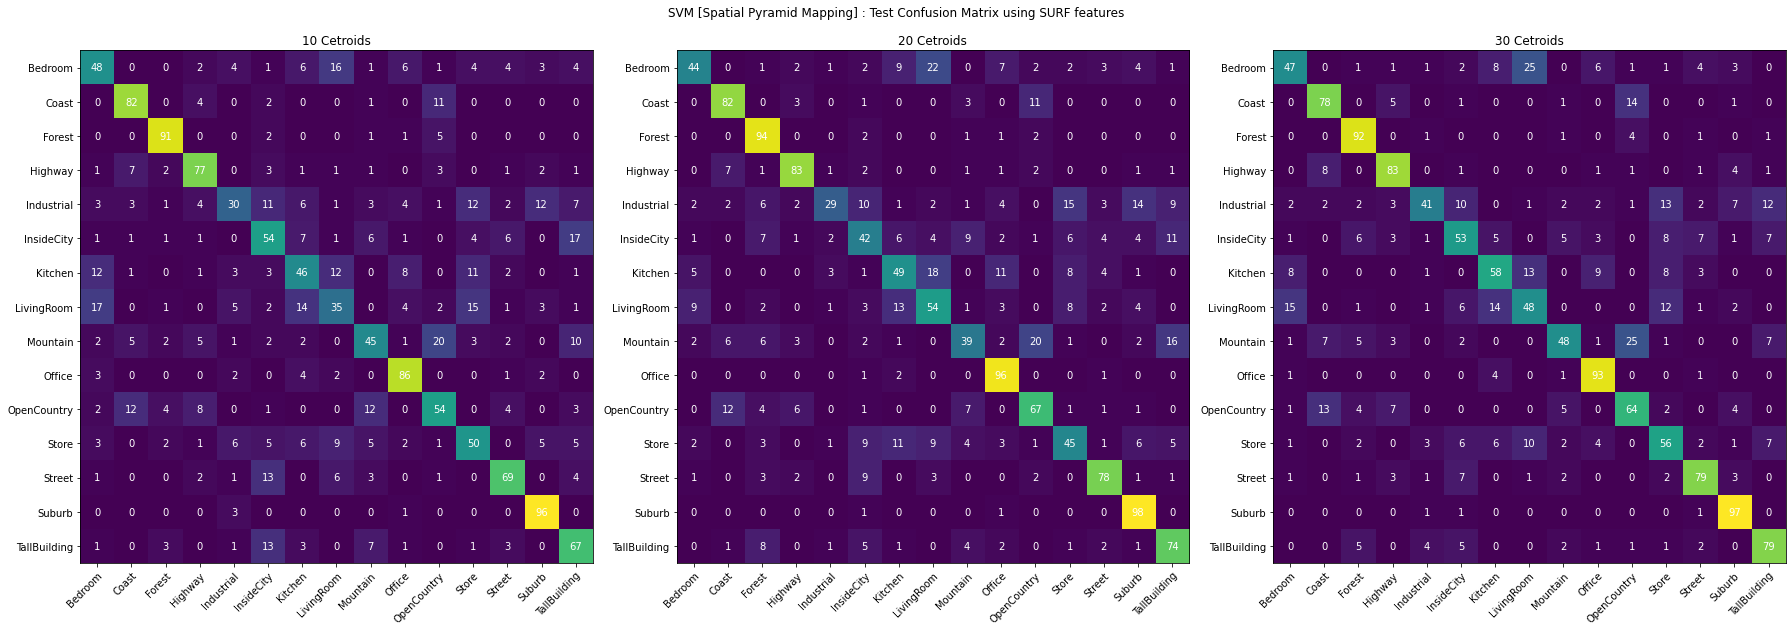

In [ ]:
plot_confusion_matrix(SURF8_c10_spatial_train_conf, SURF8_c20_spatial_train_conf, SURF8_c30_spatial_train_conf, "SVM [Spatial Pyramid Mapping] : Train Confusion Matrix using SURF features")
plot_confusion_matrix(SURF8_c10_spatial_test_conf, SURF8_c20_spatial_test_conf, SURF8_c30_spatial_test_conf, "SVM [Spatial Pyramid Mapping] : Test Confusion Matrix using SURF features")

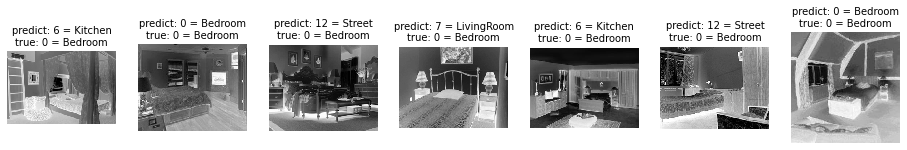

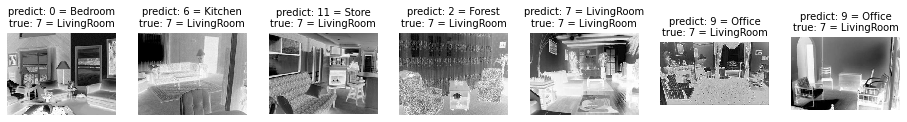

In [ ]:
plot_img(0, 7, SIFT8_c30_spatial_pred)
plot_img(710, 717, SIFT8_c30_spatial_pred)

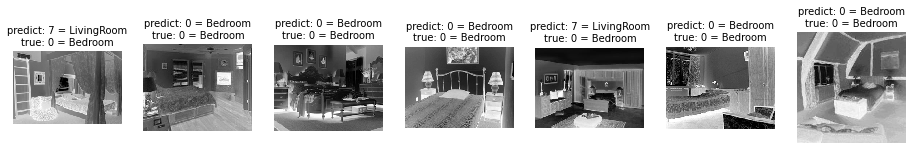

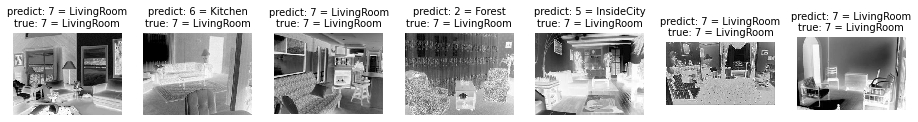

In [ ]:
plot_img(0, 7, SURF8_c30_spatial_pred)
plot_img(710, 717, SURF8_c30_spatial_pred)